In [1]:
import pandas as pd
import numpy as np
import itertools
from itertools import chain
import csv
import re
import nltk
from tqdm import tqdm
import random
from sklearn.model_selection import KFold
import time
import matplotlib.pyplot as plt
import datetime
from sentence_transformers import SentenceTransformer
import pickle
import os
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, BertConfig, BertForSequenceClassification, TrainingArguments, AutoModelForSequenceClassification, DataCollatorWithPadding, Trainer, AutoTokenizer, TFBertModel, BertModel
import torch
import torch.nn as nn
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from collections import Counter
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import classification_report
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from datasets import Dataset, DatasetDict
from evaluate import load
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\woute\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [2]:
def import_communication_data(path: str, preprocess:bool = True, remove_signoff:bool = True, newline:str = r'_/n_', reply_signs:list = None, code_words:list = None, remove_bots:bool = True, remove_names:bool = True, negation_preprocessing:bool = False, emoticon_preprocessing:bool = True, token_removal:bool = True) -> pd.DataFrame:
    print('Importing data...')
    raw_data = pd.read_csv(path, parse_dates=['reply_datetimetz']).dropna(axis = 0, subset = ['reply_from', 'reply_id', 'reply_subject', 'reply_body'])
    # Remove URLs
    raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$\-_@.&+#]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', regex = True)

    if raw_data.dtypes['reply_datetimetz']=='object':
        raw_data['reply_datetimetz'] = pd.to_datetime(raw_data['reply_datetimetz'], format = 'mixed')
    raw_data.reply_datetimetz = raw_data.reply_datetimetz.dt.tz_localize(tz = 'UTC')

    regex_newline = newline.replace('/', r'\/')
    if not preprocess:
        raw_data['reply_body'] = raw_data['reply_body'].str.replace(regex_newline, ' ', regex = True)
        raw_data['reply_subject'] = raw_data['reply_subject'].str.replace(regex_newline, ' ', regex = True)
        raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'\s\s+', ' ', regex = True)
        return raw_data
        
    
    # raw_data['reply_body'] = raw_data['reply_body'].str.replace(newline+'.*\(\).*'+newline, regex = True) # remove most code, as we remove all sentences where brackets do not contain any information --> Tekst over code willen we erin houden
    tqdm.pandas()
    print('Removing replies...')
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('(?:'+regex_newline+'\s*)+>.*?(?='+regex_newline+')', '', regex = True) # remove all replies, signified with > before the start of a sentence
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('(?:'+regex_newline+r'\s*)+\|.*?(?='+regex_newline+')', '', regex = True) # remove all replies signified with | before the start of a sentence
    print('Removing Unnecessary code-like text...')
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('-----BEGIN PGP SIGNED MESSAGE-----', '')
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('----- GICM -----', '')
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('----- SERVER -----.*$', '', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('----- CLIENT -----.*$', '', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'-----+\s* logs follow -----.*$', '', regex = True)
    
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('-----cut here-----.*-----cut here-----', '', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('-----8<-----.*-----8<-----', '', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('-----BEGIN PGP SIGNATURE-----.*-----END PGP SIGNATURE-----', '', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'(?:^|'+regex_newline+r')((?:(?!'+regex_newline+r').)*?[Ww]rote:)', '', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('----- start patch -----.*----- end patch -----', '', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('----- start -----.*----- end -----', '', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('-----+Build Errors-----.*error[^'+regex_newline+']*'+regex_newline, newline, regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'([+\-]*-----\+-----[+\-]*)'+regex_newline +r'.*([+\-]*-----\+-----[+\-]*)', r'\2', regex = True)
    raw_data['reply_body'].str.replace(r'([+\-]*-----+-----[+\-]*)', r'', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('----- Forwarded [mM]essage -----.*----- End forwarded message -----', '', regex = True)
    
    
    if remove_signoff:
        print('Removing Sign-offs...')
        raw_data['reply_body'] = raw_data['reply_body'].str.replace(regex_newline+r'\s*-+[a-zA-Z ]*\s*'+regex_newline+r'[^\-]*-*([^\-]|(\d(-\d)+))*($|([Pp].[Ss].))', '\\4', regex = True)
    
    if reply_signs:
        print('Removing e-mail replies...')
        for reply in tqdm(reply_signs):
            raw_data['reply_body'] = raw_data['reply_body'].str.replace(reply+'.*$', '', regex = True)
            
    if code_words:
        print('Removing code words...')
        for word in tqdm(code_words):
            raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'\s' + word + r'\s', '', regex = True)
    
    if remove_bots:
        print('Removing bots from entries...')
        raw_data = raw_data[~raw_data['reply_from'].str.contains(r'[\(\[\-]bot(?:[\)\]]|$)', case = False)]
        
    if remove_names:
        print('Removing Names...')
        # In order:
        # Remove quotation marks
        # Remove stuff between brackets (vaak email adressen)
        # Remove Email adresses still left in name
        # Remove dots from the name
        # Remove things added to the end of a name after - (often company of employment) (require whitespaces to make sure second names are not affected)
        # Remove entries which contain an x with a set of numbers succeeding it, as this is likely introduced by a unknown character
        # Retrieve nickname, which is usually posted between two backslashes (\...\)
        # If there is only one character (often one letter left from 2nd name/abbreviation at the start of the name), remove it
        # Remove the extra space surrounding a | token
        # Remove additional white spaces at the start/end of a token
        # Remove multiple white spaces after each other
        # Remove test and test account from the set of names
        names = set(itertools.chain(*raw_data.reply_from.str.replace('"', '').str.replace("[<(].*[>)]", '', regex = True).str.replace(r"[a-zA-Z0-9.\-_]+@\w+(.\w\w+)+", '', regex = True).str.replace('.', '').str.replace(r'\s-\s\w+($|\|)', '', regex = True).str.replace(r'(^|\|)\s*(.*),\s*(.*)($|\|)', '\\1\\3 \\2', regex = True).str.replace(r'x\d+', '', regex = True).str.replace(r'(^|\|)([^|]*)\\([^\\]+)\\([^|]*)(\||$)', '\\1\\2 \\4|\\3\\5', regex = True).str.replace(r'(^|\s)[^\|](\s|$)', ' ', regex = True).str.replace(r'\s+\|\s+', '|', regex = True).str.strip().str.replace(r'\s\s+', ' ', regex = True).str.split('|').to_list())).difference({'Test', 'Test Account', 'test', 'test account'})
        
        first_names = {name.split(' ')[0] for name in names}
        
        for name in tqdm(names):
            raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'\s+'+name+r'\s+', '', regex = True, case = False)
            
        for name in tqdm(first_names):
            raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'\s+'+name+r'\s+', '', regex = True, case = False)
        
    with open("SentiCR/SentiCR/Contractions.txt","r") as contractions,\
     open("SentiCR/SentiCR/EmoticonLookupTable.txt","r") as emotable:
        contractions_reader=csv.reader(contractions, delimiter='\t')
        emoticon_reader=csv.reader(emotable,delimiter='\t')
    
        #Hash words from dictionary with their values
        contractions_dict = {rows[0]:rows[1] for rows in contractions_reader}
        emodict={rows[0]:rows[1] for rows in emoticon_reader}
    
        contractions.close()
        emotable.close()
        
    print('Removing contractions...')
    contractions_regex = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
    raw_data['reply_body'] = raw_data['reply_body'].progress_apply(lambda x: expand_contractions(x, contractions_dict, contractions_regex))
    
    if emoticon_preprocessing:
        print('Removing emoticons...')
        for emoticon in tqdm(emodict):
            raw_data['reply_body'] = raw_data['reply_body'].str.replace(emoticon, emodict[emoticon])
            
    if negation_preprocessing:
        print('Negating text...')
        raw_data['reply_body'] = raw_data['reply_body'].progress_apply(lambda x: handle_negation(x))
        
    
    print('Removing infrequent words...')

    # split words into lists
    v = raw_data['reply_body'].str.split().tolist() # [s.split() for s in df['Col2'].tolist()]
    # compute global word frequency
    c = Counter(chain.from_iterable(v))
    # filter, join, and re-assign
    raw_data['reply_body'] = [' '.join([j for j in i if c[j] > 5]) for i in v]
        
    raw_data['reply_body'] = raw_data['reply_body'].str.replace(regex_newline, ' ', regex = True)
    raw_data['reply_subject'] = raw_data['reply_subject'].str.replace(regex_newline, ' ', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'\s\s+', ' ', regex = True)
    return raw_data
    
   
def import_dev_data(path:str, communication_data:pd.DataFrame = None, model = None, tokenizer = None, LR:bool = False, bert_messages:pd.DataFrame = None) -> pd.DataFrame:
    tqdm.pandas()
    print('Importing dev data')
    data = pd.read_csv(path, parse_dates=['From','To'])
    
    dates = data.From.unique()
    data.set_index(['Alias', 'From'], inplace = True)
    data['Messages Sent'] = data['Messages Sent'].fillna(0)
    
    print('Calculating Seasonality...')
    monthly_average = data.groupby(data.index.get_level_values('From').month)['Workload'].mean()
    mapped_monthly_average = data.index.get_level_values('From').map(lambda x: monthly_average.loc[x.month])
    
    data['standardized_workload'] = data['Workload']/mapped_monthly_average
    
    
    data['burnout'] = np.nan
    print('Calculating burnout per dev...')
    for developer in tqdm(data.index.levels[0].unique()):
        data = calculate_burnout(developer, data)
       
    print('Calculating lagged burnouts...')
    data['lagged_burnout'] = data.groupby(level=0)['burnout'].shift(periods = -1)
    data['burnout_t+1'] = data.apply(lambda x: calculate_lagged_burnout(x), axis = 1)
    data['burnout_t+3'] = (data.groupby(level=0)['burnout'].shift(periods = -3)) | (data.groupby(level=0)['burnout'].shift(periods = -2)) | (data['burnout_t+1']) 
    data['burnout_t+12'] = (data.groupby(level=0)['burnout'].shift(periods = -12)) | (data.groupby(level=0)['burnout'].shift(periods = -11)) | (data.groupby(level=0)['burnout'].shift(periods = -10)) |(data.groupby(level=0)['burnout'].shift(periods = -9)) | (data.groupby(level=0)['burnout'].shift(periods = -8)) |(data.groupby(level=0)['burnout'].shift(periods = -7)) | (data.groupby(level=0)['burnout'].shift(periods = -6)) |(data.groupby(level=0)['burnout'].shift(periods = -5)) | (data.groupby(level=0)['burnout'].shift(periods = -4)) | (data['burnout_t+3']) 
    
    print('Calculating Black Cloud...')
    data['black_cloud'] = (data['Radio Silence']) & (data.groupby(level = 0)['Radio Silence'].shift(periods = 1))
    
    if communication_data is None:
        # If we have not provided any communication_data, we only need the dev data
        return data
    
    print('Calculating quitting months')
    data['working_months'] = True # Indicate which months originally are worked in
    retrieved_dates = pd.Series(data.index.get_level_values(1).rename('Temp')).set_axis(data.index)
    # Quit happens when there are 3 consecutive months in which no work is performed or after the final month of work (which is not equivalent to the final month in the df)
    data['quit'] = (((data.Workload.isna()) &
                     (((data.groupby(level=0)['Workload'].shift(periods = -1).isna()) & (data.groupby(level=0)['Workload'].shift(periods = -2).isna())) |
                      ((data.groupby(level=0)['Workload'].shift(periods = -1).isna()) & (data.groupby(level=0)['Workload'].shift(periods = 1).isna())) |
                      ((data.groupby(level=0)['Workload'].shift(periods = 1).isna()) & (data.groupby(level=0)['Workload'].shift(periods = 2))))) | 
                    ((data.groupby(level=0)['working_months'].shift(periods = -1).isna()) & (retrieved_dates < max(retrieved_dates))) | 
                    ((data.groupby(level=0)['Workload'].shift(periods = -1).isna()) & (data.groupby(level=0)['Workload'].shift(periods = -2).isna()) & (data.groupby(level=0)['Workload'].shift(periods = -3).isna())))
    
    data['first_quit_month'] = ((data['quit']) & (~data.Workload.isna()))
    
    print('Calculating ragequit...')
    if bert_messages is None:
        data['ragequit_t+1'] = data.progress_apply(lambda x: detect_ragequit(x, communication_data, model, tokenizer), axis = 1)
    else:
        data['ragequit_t+1'] = data.progress_apply(lambda x: detect_ragequit(x, bert_messages, model, tokenizer), axis = 1)
    print('Calculating lagged ragequits...')
    data['ragequit_t+3'] = (data.groupby(level=0)['ragequit_t+1'].shift(periods = -2)) | (data.groupby(level=0)['ragequit_t+1'].shift(periods = -1)) | (data['ragequit_t+1']) 
    data['ragequit_t+12'] = (data.groupby(level=0)['ragequit_t+1'].shift(periods = -11)) | (data.groupby(level=0)['ragequit_t+1'].shift(periods = -10)) | (data.groupby(level=0)['ragequit_t+1'].shift(periods = -9)) |(data.groupby(level=0)['ragequit_t+1'].shift(periods = -8)) | (data.groupby(level=0)['ragequit_t+1'].shift(periods = -7)) |(data.groupby(level=0)['ragequit_t+1'].shift(periods = -6)) | (data.groupby(level=0)['ragequit_t+1'].shift(periods = -5)) |(data.groupby(level=0)['ragequit_t+1'].shift(periods = -4)) | (data.groupby(level=0)['ragequit_t+1'].shift(periods = -3)) | (data['ragequit_t+3']) 
    
    if LR:
        return data
    
    print('Reformatting communication dates')
    communication_data['reply_datetimetz'] = pd.to_datetime(communication_data['reply_datetimetz'], utc = True)
    communication_data['start_month'] = communication_data.progress_apply(lambda x: return_closest_date(x, dates), axis = 1)
    return communication_data.merge(data, how = 'left', left_on= ['reply_from', 'start_month'], right_index = True)

def import_network_data(path:str, communication_data:pd.DataFrame, communication:bool = True):
    print('Retrieving and combining network data...')
    network_data = pd.read_csv(path, parse_dates = ['start_datetime', 'end_datetime'])
    if communication:
        return communication_data.merge(network_data, how = 'left', left_on = 'start_month', right_on = 'start_datetime')
    else:
        communication_data.reset_index(inplace = True)
        return communication_data.merge(network_data, how = 'left', left_on = 'From', right_on = 'start_datetime')
    
    
def calculate_burnout(developer: str, all_dev_data: pd.DataFrame, decrease_percentage:float = 0.2, range = 3):
    all_days = pd.date_range(
        min(all_dev_data[all_dev_data.index.get_level_values('Alias') == developer].index.get_level_values('From')), 
        max(all_dev_data[all_dev_data.index.get_level_values('Alias') == developer].index.get_level_values('From')), 
        freq='30d')
    res_lst = []
    min_date = min(all_dev_data[all_dev_data.index.get_level_values('Alias') == developer].index.get_level_values('From'))+datetime.timedelta(days = range*30)
    for date in all_days:
        try:
            # Use try-except loop to include dates where there is no workload
            if date < min_date:
                # Cannot check the previous month for burnout, nor calculate it following the given definition of burnout, return NaN
                is_burnt_out = np.nan
            elif date == min_date:
                # For the fourth month, we simply have to calculate whether the deviation holds
                burnout_data = all_dev_data[(all_dev_data.index.get_level_values('Alias') == developer) & (all_dev_data.index.get_level_values('From') < date)]
                # Calculating the deviation, If there are too little entries, return NaN
                if len(burnout_data) < (2/3)*range:
                    is_burnt_out = np.nan
                else:
                    is_burnt_out = all_dev_data.at[(developer, date), 'standardized_workload'] < burnout_data.standardized_workload.median() * (1-decrease_percentage)
            else:
                # We first have to retrieve the last of the previous months which were not burnt-out to find the baseline
                if False in res_lst:
                    no_burnout_month = len(res_lst) - 1 - res_lst[::-1].index(False)
                    burnout_data = all_dev_data[(all_dev_data.index.get_level_values('Alias') == developer) & (all_days[no_burnout_month] < all_dev_data.index.get_level_values('From'))& (all_dev_data.index.get_level_values('From') < all_days[no_burnout_month+range])]
                    # Calculating the deviation, If there are too little entries, return NaN
                    if len(burnout_data) < (2/3)*range:
                        is_burnt_out = np.nan
                    else:
                        is_burnt_out = all_dev_data.at[(developer, date), 'standardized_workload'] < burnout_data.standardized_workload.median() * (1-decrease_percentage)
                    
                else:
                    # We need to compare the workload level of this month to the first 3 in accordance with date == min_date
                    burnout_data = all_dev_data[(all_dev_data.index.get_level_values('Alias') == developer) & (all_dev_data.index.get_level_values('From') < min_date)]
                    # Calculating the deviation, If there are too little entries, return NaN
                    if len(burnout_data) < (2/3)*range:
                        is_burnt_out = np.nan
                    else:
                        is_burnt_out = all_dev_data.at[(developer, date), 'standardized_workload'] < burnout_data.standardized_workload.median() * (1-decrease_percentage)
        except:
            # Happens when there is no workload in a given month
            is_burnt_out = np.nan
                        
        res_lst.append(is_burnt_out)
            
    res_df = pd.DataFrame({'burnout':res_lst, 'extra':res_lst}, index = pd.MultiIndex.from_tuples(itertools.product([developer], all_days), names = ['Alias', 'From']))
    # Create the rows with the new months 
    all_dev_data = all_dev_data.merge(res_df[['extra']], how = 'outer', left_index = True, right_index=True).drop('extra', axis = 1)
    # Fill the burnout of the all_dev_data
    return all_dev_data.combine_first(res_df).drop('extra', axis = 1)

def calculate_lagged_burnout(data: pd.Series) -> bool:
    if np.isnan(data.burnout):
        return data.lagged_burnout
    elif np.isnan(data.lagged_burnout):
        return data.burnout
    else: 
        return data.burnout or data.lagged_burnout
        

def detect_ragequit(dev_data: pd.Series, communication_data: pd.DataFrame, model, tokenizer):
    if not dev_data.quit:
        # Can never be ragequit if dev hasn't quit
        return False
    elif dev_data.first_quit_month:
        # Dev will quit somewhere in this time period, therefore, we will need to retrieve the closest message to the end of the month to analyse
        last_date = dev_data.To
    else:
        # Not accurate if there is still communication months after the work has stopped, but feels like necessary evil to reduce calculation times and to refrain from having to go through the entire dataframe to search for the first_quit_month
        last_date = dev_data.name[1]
        
    
    dev_name = dev_data.name[0]
    try:
        dev_communication = communication_data[(communication_data.reply_from == dev_name) & (pd.to_datetime(communication_data.reply_datetimetz) < last_date)]
        last_message = dev_communication[dev_communication['reply_datetimetz'] == max(dev_communication.reply_datetimetz)].iloc[0]['reply_body']
        inputs = tokenizer(last_message, return_tensors = 'pt')
        softmax = torch.nn.functional.softmax(model(**inputs)['logits'], dim=-1)
        return softmax[0,2].item() > softmax[0,1].item() and softmax[0,2].item() > 0.15
    
    except:
        # If the developer has no messages (before the quitting date), the previous code would return an error, therefore, these developers do not rage quit, but rather silently quit
        return False
    
# def calculate_future_burnout_3(observation: pd.Series, data: pd.DataFrame) -> bool:
#     if 
        

def return_closest_date(reply: pd.Series, date_range: list):
    return date_range[pd.Series([reply.reply_datetimetz - date if (reply.reply_datetimetz - date) > datetime.timedelta(seconds = 0) else datetime.timedelta(days = 50) for date in date_range]).idxmin()]

def expand_contractions(s, contractions_dict, contractions_regex):
     def replace(match):
         return contractions_dict[match.group(0)]
     return contractions_regex.sub(replace, s.lower())

def handle_negation(comments):
    grammar= r"""
    NegP: {<VERB>?<ADV>+<VERB|ADJ>?<PRT|ADV><VERB>}
    {<VERB>?<ADV>+<VERB|ADJ>*<ADP|DET>?<ADJ>?<NOUN>?<ADV>?}
    
    """
    chunk_parser = nltk.RegexpParser(grammar)
    sentences = nltk.sent_tokenize(comments)
    modified_st=[]
    for st in sentences:
        allwords = nltk.word_tokenize(st)
        modified_words=[]
        if negated(allwords):
            part_of_speech = nltk.tag.pos_tag(allwords,tagset='universal')
            chunked = chunk_parser.parse(part_of_speech)
            #print("---------------------------")
            #print(st)
            for n in chunked:
                if isinstance(n, nltk.tree.Tree):
                    words = [pair[0] for pair in n.leaves()]
                    #print(words)

                    if n.label() == 'NegP' and negated(words):
                        for i, (word, pos) in enumerate(n.leaves()):
                            if (pos=="ADV" or pos=="ADJ" or pos=="VERB") and (word!="not"):
                                modified_words.append(prepend_not(word))
                            else:
                                modified_words.append(word)
                    else:
                         modified_words.extend(words)
                else:
                    modified_words.append(n[0])
            newst =' '.join(modified_words)
            #print(newst)
            modified_st.append(newst)
        else:
            modified_st.append(st)
    return ". ".join(modified_st)

def negated(input_words):
    """
    Determine if input contains negation words
    """
    negation_words =['not', 'never', 'none', 'nobody', 'nowhere', 'neither', 'barely', 'hardly',
                     'nothing', 'rarely', 'seldom', 'despite' ]

    emoticon_words=['PositiveSentiment','NegativeSentiment']

    neg_words = []
    neg_words.extend(negation_words)
    for word in neg_words:
        if word in input_words:
            return True
    return False

def prepend_not(word):
    negation_words =['not', 'never', 'none', 'nobody', 'nowhere', 'neither', 'barely', 'hardly',
                     'nothing', 'rarely', 'seldom', 'despite' ]

    emoticon_words=['PositiveSentiment','NegativeSentiment']
    if word in emoticon_words:
        return word
    elif word in negation_words:
        return word
    return "NOT_"+word



In [3]:
geronimo_emails = ['----- Mensaje Original -----',
 '----- Methods required by DeploymentManager -----',
 '----- Methods required to populate Property Editors -----',
 '----- Oorspronkelijk bericht -----',
 '----- Original Message -----',
'-----Email-----',
 '-----Mensagem original-----',
 '-----Mensaje original-----',
 '-----Oorspronkelijk bericht-----',
 '-----Original Email-----',
 '-----Original Message-----',
 '-----Ursprungliche Nachricht-----',
 '-----Ursprungligt meddelande-----',
 '-----UrsprÃ¼ngliche Nachricht-----',
 '----- Forwarded Message -----',
 '----- Forwarded message -----']

code_words = ['while', 'case', 'switch','def', 'abstract','byte','continue','native','private','synchronized',
 'if', 'do', 'include', 'each', 'than', 'finally', 'class', 'double', 'float', 'int','else','instanceof',
 'long', 'super', 'import', 'short', 'default', 'catch', 'try', 'new', 'final', 'extends', 'implements',
 'public', 'protected', 'static', 'this', 'return', 'char', 'const', 'break', 'boolean', 'bool', 'package',
 'byte', 'assert', 'raise', 'global', 'with', 'or', 'yield', 'in', 'out', 'except', 'and', 'enum', 'signed',
 'void', 'virtual', 'union', 'goto', 'var', 'function', 'require', 'print', 'echo', 'foreach', 'elseif', 'namespace',
 'delegate', 'event', 'override', 'struct', 'readonly', 'explicit', 'interface', 'get', 'set','elif','for',
 'throw','throws','lambda','endfor','endforeach','endif','endwhile','clone']

In [4]:
csv_path = "dev-sentiment/train_df_final.csv"
text_column = "Text"  # Change this if your column is named differently

# Output paths
output_txt = "train_corpus.txt"
tokenizer_dir = "custom-bert-tokenizer"
vocab_size = 28996  # MUST match the vocab size expected by your model

print("Reading CSV...")
df = pd.read_csv(csv_path)
df[text_column] = df[text_column].astype(str)
df[text_column].dropna().to_csv(output_txt, index=False, header=False)

print(f"Extracted {len(df)} lines of text to {output_txt}...")

# === Step 3: Train the Tokenizer ===

print("Training WordPiece tokenizer...")
tokenizer = BertWordPieceTokenizer(lowercase=True)

tokenizer.train(
    files=output_txt,
    vocab_size=vocab_size,
    min_frequency=2,
    limit_alphabet=1000,
    special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]
)

# Save the trained tokenizer
os.makedirs(tokenizer_dir, exist_ok=True)
tokenizer.save_model(tokenizer_dir)

# Save in Hugging Face format
hf_tokenizer = BertTokenizer.from_pretrained(tokenizer_dir)
hf_tokenizer.save_pretrained(tokenizer_dir)

print(f"Tokenizer saved to: {tokenizer_dir}")


Reading CSV...
Extracted 4068 lines of text to train_corpus.txt...
Training WordPiece tokenizer...
Tokenizer saved to: custom-bert-tokenizer


# Geronimo Analysis

In [5]:
project_name = 'helix'
start_year = 2015
end_year = 2020
tokenizer = BertTokenizer.from_pretrained("custom-bert-tokenizer")

# Set the vocab size to match the checkpoint
config = BertConfig.from_pretrained("bert-base-uncased", num_labels=3)
config.vocab_size = 28996  # important!

# Initialize the model with the updated config
model = BertForSequenceClassification(config)

# Load the checkpoint
state_dict = torch.load("dev-sentiment/bert_model.pt", map_location="cpu")
model.load_state_dict(state_dict)

# Ik moet wel nog steeds de NaNs in ragequit+3 en +12 vullen als +1 al True is

communication_test = import_communication_data("Test/data/"+project_name+"_communication_"+str(start_year)+"-"+str(end_year)+".csv", reply_signs=geronimo_emails, remove_names=True, negation_preprocessing=False, code_words=code_words)
dev_test = import_dev_data('Test/data/dev_data_'+project_name+'.csv', communication_test, model, tokenizer)
all_test = import_network_data('Test/data/network_data_'+project_name+'.csv', dev_test)

all_test

Importing data...
Removing replies...
Removing Unnecessary code-like text...
Removing Sign-offs...
Removing e-mail replies...


100%|██████████| 16/16 [00:00<00:00, 45.20it/s]


Removing code words...


100%|██████████| 88/88 [00:10<00:00,  8.30it/s]


Removing bots from entries...
Removing Names...


100%|██████████| 139/139 [00:31<00:00,  4.44it/s]


Removing contractions...


100%|██████████| 7356/7356 [00:01<00:00, 5509.29it/s] 


Removing emoticons...


100%|██████████| 96/96 [00:01<00:00, 88.29it/s] 


Removing infrequent words...
Importing dev data
Calculating Seasonality...
Calculating burnout per dev...


100%|██████████| 44/44 [00:01<00:00, 24.49it/s]


Calculating lagged burnouts...
Calculating Black Cloud...
Calculating quitting months
Calculating ragequit...


100%|██████████| 511/511 [01:01<00:00,  8.25it/s]


Calculating lagged ragequits...
Reformatting communication dates


100%|██████████| 7356/7356 [00:28<00:00, 261.88it/s]


Retrieving and combining network data...


,identity_id,reply_from,reply_id,in_reply_to_id,reply_datetimetz,reply_to,reply_cc,reply_subject,reply_body,reply_tz,...,end_datetime,st_congruence,reply_degree,reply_close,reply_between,git_degree,git_close,git_between,reply_density,git_density
0,2,Lei Xia <lxia@linkedin.com> | Lei Xia <lxia@lx...,HELIX-599,NaN,2015-06-04 20:55:16+00:00,NaN,NaN,HELIX-599,in we have scenario that there will be multipl...,0,...,2015-07-04 05:43:46+00:00,0.000000,0.214286,NaN,0.047619,0.000000,NaN,NaN,0.071429,1.000000
1,2,Lei Xia <lxia@linkedin.com> | Lei Xia <lxia@lx...,512931683,NaN,2019-07-18 18:24:15+00:00,NaN,NaN,341,"if you are only repo to the code, can we use o...",0,...,2019-08-12 05:43:46+00:00,0.250000,0.395238,NaN,0.224322,0.266667,NaN,0.388889,0.247619,0.177778
2,2,Lei Xia <lxia@linkedin.com> | Lei Xia <lxia@lx...,513428194,NaN,2019-07-20 02:32:37+00:00,NaN,NaN,346,a single there are 4 can they be combined to one,0,...,2019-08-12 05:43:46+00:00,0.250000,0.395238,NaN,0.224322,0.266667,NaN,0.388889,0.247619,0.177778
3,2,Lei Xia <lxia@linkedin.com> | Lei Xia <lxia@lx...,HELIX-660,NaN,2017-06-10 00:17:36+00:00,NaN,NaN,HELIX-660,when writing to a using are corner cases they ...,0,...,2017-06-23 05:43:46+00:00,0.142857,0.250000,NaN,0.020408,0.300000,0.622222,0.291667,0.178571,0.700000
4,2,Lei Xia <lxia@linkedin.com> | Lei Xia <lxia@lx...,<CAFGR15yWwkTskxwajAm2NXQJHQv3z+fKfAgr-qG0RZcX...,<CAHF_-rjNthbjx91NnAzu1RAPE-8BNdTVJ8KUcQNabmWq...,2020-01-23 13:46:31+00:00,dev@helix.apache.org,NaN,Re: [VOTE] Apache Helix 0.9.4 Release,,-0800,...,2020-02-08 05:43:46+00:00,0.294118,0.352941,NaN,0.269401,0.400000,NaN,0.230453,0.147059,0.377778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7351,153,Kevin Lafferty <kevin.lafferty@gmail.com>,<CAMbUaVFpKey257Pn_jkTKuG10qya82SEno3Z4BJ0nKaS...,NaN,2019-04-29 22:54:03+00:00,dev@helix.apache.org,NaN,Java 11 support?,i did a quick the mailing not find any discuss...,-0700,...,2019-05-14 05:43:46+00:00,1.000000,0.150000,NaN,0.000000,0.000000,NaN,0.000000,0.100000,0.000000
7352,154,Chris Lambertus <cml@apache.org>,<DC05A7BC-69E2-4D57-B247-C574AF34E35C@apache.org>,<CAHF_-rjbRqqgWFwVabWLk9uqrq5UQGGbSa07=5Jvs7RQ...,2019-05-23 23:49:03+00:00,Hunter Lee <hulee@apache.org>,"users@infra.apache.org, dev@helix.apache.org",Re: Enabling issues and wiki on Apache GitHub,jira ticket,-0700,...,2019-06-13 05:43:46+00:00,0.400000,0.357143,NaN,0.201814,0.266667,NaN,0.240000,0.357143,0.333333
7353,155,Geoffroy Fouquier <geoffroy.fouquier@exensa.com>,<3cb3d77a-2e6d-7353-55be-4bf816480878@exensa.com>,NaN,2020-03-11 09:35:53+00:00,<dev@helix.apache.org>,NaN,User-defined rebalancer,â i am trying success a user-defined not under...,+0100,...,2020-04-08 05:43:46+00:00,0.230769,0.296703,NaN,0.206114,0.250000,NaN,0.229025,0.087912,0.464286
7354,156,Tom DuBuisson <tommd@muse.dev>,<CAF_Lw0eh4LrEVFw0LAwoi6kqy=XEX=OSwiEzy3BsHYOe...,NaN,2020-09-22 22:12:44+00:00,dev@helix.apache.org,NaN,ApacheCon Bug Bash,helix part of our of our is doing a we will br...,-0700,...,2020-10-05 05:43:46+00:00,0.200000,0.138095,NaN,0.029827,0.250000,NaN,0.265306,0.076190,0.178571


In [6]:
all_test[['burnout', 'burnout_t+1', 'burnout_t+3', 'burnout_t+12', 'ragequit_t+1', 'ragequit_t+3', 'ragequit_t+12']].mean()

burnout          0.218515
burnout_t+1      0.452266
burnout_t+3      0.238593
burnout_t+12     0.261132
ragequit_t+1     0.000825
ragequit_t+3     0.008246
ragequit_t+12    0.022265
dtype: object

In [7]:
all_test.to_csv('Test/data/'+project_name+'_all_message_data.csv')

In [3]:
all_test = pd.read_csv('Test/data/helix_all_message_data.csv', parse_dates = ['reply_datetimetz', 'start_month', 'To', 'start_datetime', 'end_datetime']).drop('Unnamed: 0', axis = 1)
all_test

,identity_id,reply_from,reply_id,in_reply_to_id,reply_datetimetz,reply_to,reply_cc,reply_subject,reply_body,reply_tz,...,end_datetime,st_congruence,reply_degree,reply_close,reply_between,git_degree,git_close,git_between,reply_density,git_density
0,2,Lei Xia <lxia@linkedin.com> | Lei Xia <lxia@lx...,HELIX-599,NaN,2015-06-04 20:55:16+00:00,NaN,NaN,HELIX-599,in we have scenario that there will be multipl...,0,...,2015-07-04 05:43:46+00:00,0.000000,0.214286,NaN,0.047619,0.000000,NaN,NaN,0.071429,1.000000
1,2,Lei Xia <lxia@linkedin.com> | Lei Xia <lxia@lx...,512931683,NaN,2019-07-18 18:24:15+00:00,NaN,NaN,341,"if you are only repo to the code, can we use o...",0,...,2019-08-12 05:43:46+00:00,0.250000,0.395238,NaN,0.224322,0.266667,NaN,0.388889,0.247619,0.177778
2,2,Lei Xia <lxia@linkedin.com> | Lei Xia <lxia@lx...,513428194,NaN,2019-07-20 02:32:37+00:00,NaN,NaN,346,a single there are 4 can they be combined to one,0,...,2019-08-12 05:43:46+00:00,0.250000,0.395238,NaN,0.224322,0.266667,NaN,0.388889,0.247619,0.177778
3,2,Lei Xia <lxia@linkedin.com> | Lei Xia <lxia@lx...,HELIX-660,NaN,2017-06-10 00:17:36+00:00,NaN,NaN,HELIX-660,when writing to a using are corner cases they ...,0,...,2017-06-23 05:43:46+00:00,0.142857,0.250000,NaN,0.020408,0.300000,0.622222,0.291667,0.178571,0.700000
4,2,Lei Xia <lxia@linkedin.com> | Lei Xia <lxia@lx...,<CAFGR15yWwkTskxwajAm2NXQJHQv3z+fKfAgr-qG0RZcX...,<CAHF_-rjNthbjx91NnAzu1RAPE-8BNdTVJ8KUcQNabmWq...,2020-01-23 13:46:31+00:00,dev@helix.apache.org,NaN,Re: [VOTE] Apache Helix 0.9.4 Release,NaN,-0800,...,2020-02-08 05:43:46+00:00,0.294118,0.352941,NaN,0.269401,0.400000,NaN,0.230453,0.147059,0.377778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7351,153,Kevin Lafferty <kevin.lafferty@gmail.com>,<CAMbUaVFpKey257Pn_jkTKuG10qya82SEno3Z4BJ0nKaS...,NaN,2019-04-29 22:54:03+00:00,dev@helix.apache.org,NaN,Java 11 support?,i did a quick the mailing not find any discuss...,-0700,...,2019-05-14 05:43:46+00:00,1.000000,0.150000,NaN,0.000000,0.000000,NaN,0.000000,0.100000,0.000000
7352,154,Chris Lambertus <cml@apache.org>,<DC05A7BC-69E2-4D57-B247-C574AF34E35C@apache.org>,<CAHF_-rjbRqqgWFwVabWLk9uqrq5UQGGbSa07=5Jvs7RQ...,2019-05-23 23:49:03+00:00,Hunter Lee <hulee@apache.org>,"users@infra.apache.org, dev@helix.apache.org",Re: Enabling issues and wiki on Apache GitHub,jira ticket,-0700,...,2019-06-13 05:43:46+00:00,0.400000,0.357143,NaN,0.201814,0.266667,NaN,0.240000,0.357143,0.333333
7353,155,Geoffroy Fouquier <geoffroy.fouquier@exensa.com>,<3cb3d77a-2e6d-7353-55be-4bf816480878@exensa.com>,NaN,2020-03-11 09:35:53+00:00,<dev@helix.apache.org>,NaN,User-defined rebalancer,â i am trying success a user-defined not under...,+0100,...,2020-04-08 05:43:46+00:00,0.230769,0.296703,NaN,0.206114,0.250000,NaN,0.229025,0.087912,0.464286
7354,156,Tom DuBuisson <tommd@muse.dev>,<CAF_Lw0eh4LrEVFw0LAwoi6kqy=XEX=OSwiEzy3BsHYOe...,NaN,2020-09-22 22:12:44+00:00,dev@helix.apache.org,NaN,ApacheCon Bug Bash,helix part of our of our is doing a we will br...,-0700,...,2020-10-05 05:43:46+00:00,0.200000,0.138095,NaN,0.029827,0.250000,NaN,0.265306,0.076190,0.178571


In [9]:
dev_data = import_dev_data('Test/data/dev_data_'+project_name+'.csv', communication_test, model, tokenizer, LR = True)
logistic_data = import_network_data('Test/data/network_data_'+project_name+'.csv', dev_data, communication=False).dropna(axis = 0, subset = ['Radio Silence', 'Organisational Silo', 'Lone Wolf'])
logistic_data.to_csv('Test/data/'+project_name+'_logistic_data.csv')
logistic_data

Importing dev data
Calculating Seasonality...
Calculating burnout per dev...


100%|██████████| 44/44 [00:01<00:00, 36.01it/s]


Calculating lagged burnouts...
Calculating Black Cloud...
Calculating quitting months
Calculating ragequit...


100%|██████████| 511/511 [00:37<00:00, 13.68it/s]


Calculating lagged ragequits...
Retrieving and combining network data...


,Alias,From,Avg. distance,Lone Wolf,Messages Sent,Organisational Silo,Radio Silence,To,Workload,burnout,...,end_datetime,st_congruence,reply_degree,reply_close,reply_between,git_degree,git_close,git_between,reply_density,git_density
0,Ali Najari <anajari@anajari-ld1.linkedin.biz>,2019-07-13 05:43:46+00:00,NaN,True,0.0,True,False,2019-08-12 05:43:46+00:00,2.0,NaN,...,2019-08-12 05:43:46+00:00,0.250000,0.395238,NaN,0.224322,0.266667,NaN,0.388889,0.247619,0.177778
1,Ali Reza Zamani Zadeh Najari <anajari@linkedin...,2019-07-13 05:43:46+00:00,NaN,True,0.0,True,False,2019-08-12 05:43:46+00:00,59.0,NaN,...,2019-08-12 05:43:46+00:00,0.250000,0.395238,NaN,0.224322,0.266667,NaN,0.388889,0.247619,0.177778
2,Ali Reza Zamani Zadeh Najari <anajari@linkedin...,2019-08-12 05:43:46+00:00,NaN,True,0.0,True,False,2019-09-11 05:43:46+00:00,834.0,NaN,...,2019-09-11 05:43:46+00:00,0.500000,0.560440,NaN,0.486193,0.214286,NaN,0.177778,0.208791,0.285714
3,Ali Reza Zamani Zadeh Najari <anajari@linkedin...,2019-09-11 05:43:46+00:00,NaN,True,0.0,True,False,2019-10-11 05:43:46+00:00,101.0,NaN,...,2019-10-11 05:43:46+00:00,0.428571,0.277778,NaN,0.031250,0.333333,NaN,0.200000,0.222222,0.333333
5,Ali Reza Zamani Zadeh Najari <anajari@linkedin...,2019-11-10 05:43:46+00:00,NaN,True,0.0,True,False,2019-12-10 05:43:46+00:00,1424.0,False,...,2019-12-10 05:43:46+00:00,0.500000,0.480952,NaN,0.342229,0.452381,NaN,0.350000,0.161905,0.380952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,zhangmeng916 <56051770+zhangmeng916@users.nore...,2020-01-09 05:43:46+00:00,3.0,True,15.0,True,True,2020-02-08 05:43:46+00:00,1621.0,NaN,...,2020-02-08 05:43:46+00:00,0.294118,0.352941,NaN,0.269401,0.400000,NaN,0.230453,0.147059,0.377778
506,zhangmeng916 <56051770+zhangmeng916@users.nore...,2020-02-08 05:43:46+00:00,5.0,True,22.0,True,True,2020-03-09 05:43:46+00:00,1041.0,NaN,...,2020-03-09 05:43:46+00:00,0.307692,0.318681,NaN,0.275148,0.488889,0.662607,0.719136,0.142857,0.288889
507,zhangmeng916 <56051770+zhangmeng916@users.nore...,2020-03-09 05:43:46+00:00,2.6,True,25.0,True,True,2020-04-08 05:43:46+00:00,1897.0,NaN,...,2020-04-08 05:43:46+00:00,0.230769,0.296703,NaN,0.206114,0.250000,NaN,0.229025,0.087912,0.464286
508,zzhang <zzhang@apache.org> | zzhang <zzhang5@u...,2015-01-05 05:43:46+00:00,NaN,False,0.0,False,False,2015-02-04 05:43:46+00:00,236.0,NaN,...,2015-02-04 05:43:46+00:00,1.000000,0.166667,NaN,0.000000,NaN,NaN,NaN,0.166667,NaN


In [4]:
project_name = 'helix'
start_year = 2015
end_year = 2020

logistic_data = pd.read_csv('Test/data/'+project_name+'_logistic_data.csv', parse_dates = ['To', 'start_datetime', 'end_datetime']).astype({'burnout':bool}).drop('Unnamed: 0', axis = 1)
logistic_data

,Alias,From,Avg. distance,Lone Wolf,Messages Sent,Organisational Silo,Radio Silence,To,Workload,burnout,...,end_datetime,st_congruence,reply_degree,reply_close,reply_between,git_degree,git_close,git_between,reply_density,git_density
0,Ali Najari <anajari@anajari-ld1.linkedin.biz>,2019-07-13 05:43:46+00:00,NaN,True,0.0,True,False,2019-08-12 05:43:46+00:00,2.0,True,...,2019-08-12 05:43:46+00:00,0.250000,0.395238,NaN,0.224322,0.266667,NaN,0.388889,0.247619,0.177778
1,Ali Reza Zamani Zadeh Najari <anajari@linkedin...,2019-07-13 05:43:46+00:00,NaN,True,0.0,True,False,2019-08-12 05:43:46+00:00,59.0,True,...,2019-08-12 05:43:46+00:00,0.250000,0.395238,NaN,0.224322,0.266667,NaN,0.388889,0.247619,0.177778
2,Ali Reza Zamani Zadeh Najari <anajari@linkedin...,2019-08-12 05:43:46+00:00,NaN,True,0.0,True,False,2019-09-11 05:43:46+00:00,834.0,True,...,2019-09-11 05:43:46+00:00,0.500000,0.560440,NaN,0.486193,0.214286,NaN,0.177778,0.208791,0.285714
3,Ali Reza Zamani Zadeh Najari <anajari@linkedin...,2019-09-11 05:43:46+00:00,NaN,True,0.0,True,False,2019-10-11 05:43:46+00:00,101.0,True,...,2019-10-11 05:43:46+00:00,0.428571,0.277778,NaN,0.031250,0.333333,NaN,0.200000,0.222222,0.333333
4,Ali Reza Zamani Zadeh Najari <anajari@linkedin...,2019-11-10 05:43:46+00:00,NaN,True,0.0,True,False,2019-12-10 05:43:46+00:00,1424.0,False,...,2019-12-10 05:43:46+00:00,0.500000,0.480952,NaN,0.342229,0.452381,NaN,0.350000,0.161905,0.380952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,zhangmeng916 <56051770+zhangmeng916@users.nore...,2020-01-09 05:43:46+00:00,3.0,True,15.0,True,True,2020-02-08 05:43:46+00:00,1621.0,True,...,2020-02-08 05:43:46+00:00,0.294118,0.352941,NaN,0.269401,0.400000,NaN,0.230453,0.147059,0.377778
344,zhangmeng916 <56051770+zhangmeng916@users.nore...,2020-02-08 05:43:46+00:00,5.0,True,22.0,True,True,2020-03-09 05:43:46+00:00,1041.0,True,...,2020-03-09 05:43:46+00:00,0.307692,0.318681,NaN,0.275148,0.488889,0.662607,0.719136,0.142857,0.288889
345,zhangmeng916 <56051770+zhangmeng916@users.nore...,2020-03-09 05:43:46+00:00,2.6,True,25.0,True,True,2020-04-08 05:43:46+00:00,1897.0,True,...,2020-04-08 05:43:46+00:00,0.230769,0.296703,NaN,0.206114,0.250000,NaN,0.229025,0.087912,0.464286
346,zzhang <zzhang@apache.org> | zzhang <zzhang5@u...,2015-01-05 05:43:46+00:00,NaN,False,0.0,False,False,2015-02-04 05:43:46+00:00,236.0,True,...,2015-02-04 05:43:46+00:00,1.000000,0.166667,NaN,0.000000,NaN,NaN,NaN,0.166667,NaN


# Modeling

### Burnout - LR

In [11]:
burnout_logistic_data = logistic_data[~logistic_data.burnout.isna()].drop(['burnout_t+1', 'burnout_t+3', 'burnout_t+12', 'ragequit_t+1', 'ragequit_t+3', 'ragequit_t+12', 'git_close', 'Workload'], axis = 1).drop_duplicates().drop(['Alias', 'From', 'To', 'start_datetime', 'end_datetime', 'lagged_burnout', 'reply_close', 'working_months', 'quit', 'first_quit_month', 'git_degree'], axis = 1).dropna().astype({'burnout':bool})
logistic_train_data, logistic_test_data = train_test_split(burnout_logistic_data, test_size = 0.2, random_state = 404, stratify = burnout_logistic_data['burnout'])

Positive cases: 100
New length of train set: 116


C:\Users\woute\AppData\Local\Temp\ipykernel_4596\2990934316.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  logistic_train_data = logistic_train_data.groupby('burnout').apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)


In [12]:
logistic_train_data.describe(include = 'all')

,Avg. distance,Lone Wolf,Messages Sent,Organisational Silo,Radio Silence,burnout,standardized_workload,black_cloud,st_congruence,reply_degree,reply_between,git_between,reply_density,git_density
count,116.000000,116,116.000000,116,116,116,116.000000,116,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000
unique,NaN,2,NaN,2,2,2,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,True,NaN,True,True,False,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,105,NaN,74,109,58,NaN,77,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.355850,NaN,20.801724,NaN,NaN,NaN,1.319084,NaN,0.262911,0.262625,0.157635,0.283636,0.151235,0.369130
std,1.045767,NaN,21.619725,NaN,NaN,NaN,2.198824,NaN,0.206478,0.132255,0.151837,0.243858,0.090000,0.172673
min,1.000000,NaN,1.000000,NaN,NaN,NaN,0.001583,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.044444
25%,1.666667,NaN,6.750000,NaN,NaN,NaN,0.246055,NaN,0.111111,0.142857,0.027473,0.083333,0.076190,0.238095
50%,2.000000,NaN,15.000000,NaN,NaN,NaN,0.696337,NaN,0.250000,0.261364,0.144101,0.229025,0.161905,0.333333
75%,2.850000,NaN,27.250000,NaN,NaN,NaN,1.317929,NaN,0.400000,0.352941,0.269401,0.388889,0.206044,0.400000


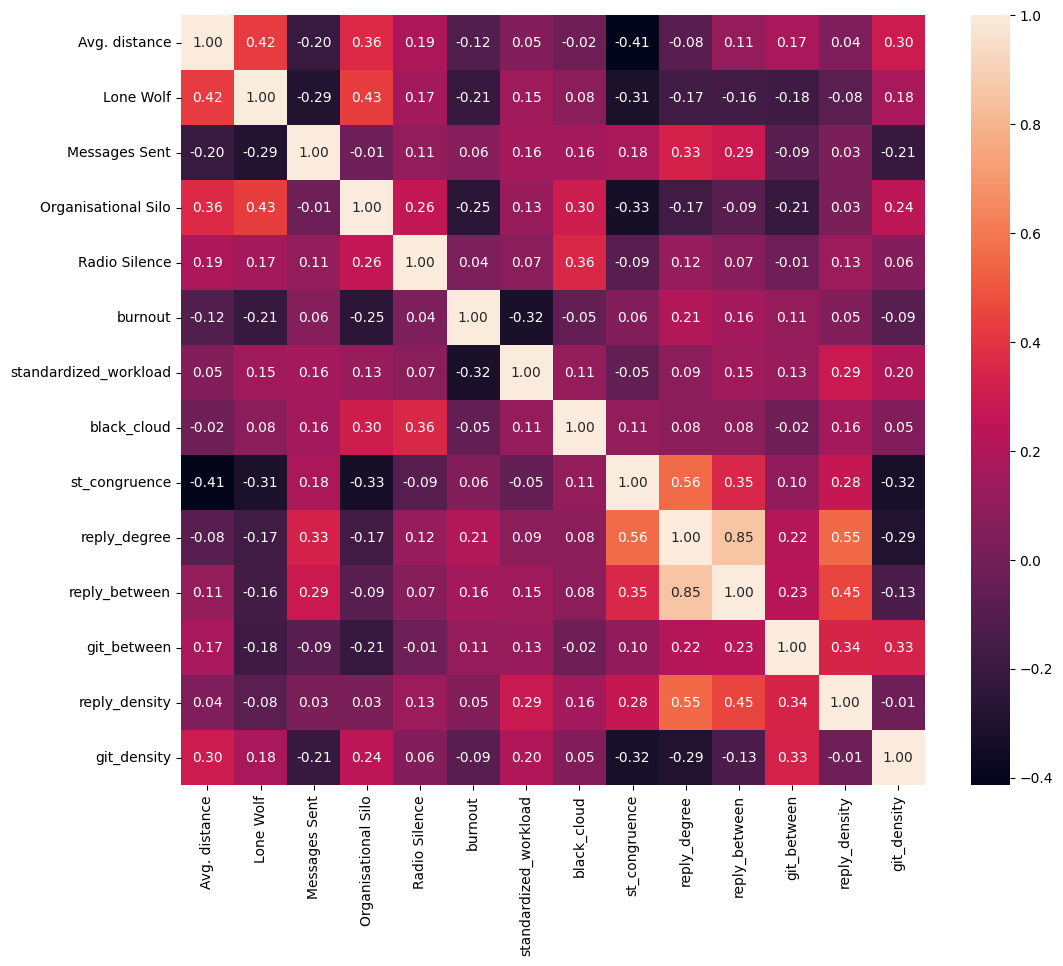

In [13]:
fig = plt.figure(figsize=(12,10))
ax= plt.subplot()
sns.heatmap(logistic_train_data.astype(float).corr(), annot=True, ax = ax, fmt = '.2f');
fig.savefig('correlations_geronimo.png')

In [14]:
lr_model = LogisticRegressionCV(max_iter = 1000000).fit(logistic_train_data.drop('burnout', axis = 1), logistic_train_data['burnout'])

Text(45.722222222222214, 0.5, 'True class')

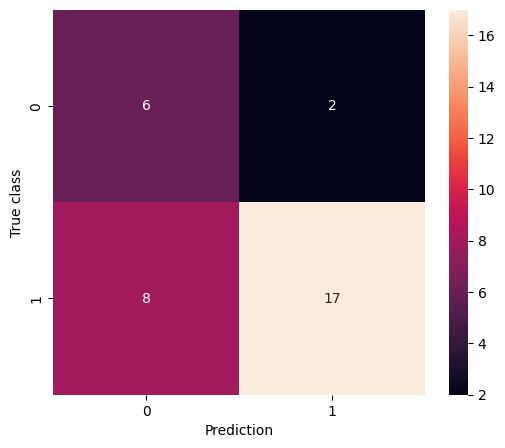

In [15]:
cm = confusion_matrix(logistic_test_data['burnout'], lr_model.predict(logistic_test_data.drop('burnout', axis = 1)))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

statsmodels

In [16]:
stat_model = sm.Logit(logistic_train_data['burnout'].astype(float), sm.add_constant(logistic_train_data.drop('burnout', axis = 1)).astype(float)).fit(disp = 0)
stat_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                burnout   No. Observations:                  116
Model:                          Logit   Df Residuals:                      102
Method:                           MLE   Df Model:                           13
Date:                Tue, 27 May 2025   Pseudo R-squ.:                  0.2391
Time:                        15:26:11   Log-Likelihood:                -61.184
converged:                       True   LL-Null:                       -80.405
Covariance Type:            nonrobust   LLR p-value:                 0.0002453
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.3477      1.438      0.242      0.809      -2.470       3.165
Avg. distance            -0.3508      0.283     -1.241      0.214      -0.905       0.203
Lone Wolf                 0.0482      1.120      0.043      0.966      -2.147       2.243
Messages Sent             0.0176      0.019      0.914      0.361      -0.020       0.055
Organisational Silo      -1.0827      0.599     -1.807      0.071      -2.257       0.092
Radio Silence             0.9736      1.034      0.941      0.347      -1.054       3.001
standardized_workload    -1.0885      0.395     -2.757      0.006      -1.862      -0.315
black_cloud              -0.1749      0.552     -0.317      0.752      -1.257       0.907
st_congruence            -2.8890      1.631     -1.771      0.077      -6.086       0.308
reply_degree              5.1965      4.835      1.075      0.283      -4.281      14.674
reply_between             0.8541      3.253      0.263      0.793      -5.521       7.230
git_between               0.6499      1.125      0.578      0.563      -1.555       2.854
reply_density            -1.9768      3.546     -0.557      0.577      -8.927       4.973
git_density               1.1606      1.549      0.749      0.454      -1.875       4.196
=========================================================================================
"""

Text(45.722222222222214, 0.5, 'True class')

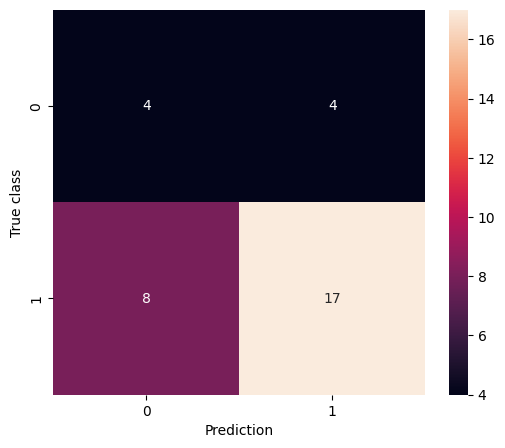

In [17]:
cm = confusion_matrix(logistic_test_data['burnout'], round(stat_model.predict(sm.add_constant(logistic_test_data.drop('burnout', axis = 1)).astype(float))).astype(int))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

### Burnout NB

In [70]:
message_data = all_test[['reply_body', 'burnout']].dropna()

nlp = spacy.load('en_core_web_sm')
tqdm.pandas()

message_data['lemmas'] = message_data.reply_body.progress_apply(lambda x: [token.lemma_ for token in nlp(handle_negation(x)) if not token.is_stop and token.is_alpha])
message_data['burnout'] = message_data['burnout'].astype(bool)
message_data

100%|██████████| 925/925 [00:22<00:00, 40.73it/s] 


,reply_body,burnout,lemmas
0,in we have scenario that there will be multipl...,False,"[scenario, multiple, helix, different, instanc..."
8,has some he is on the fix so i am,True,[fix]
22,more details on the proposed solution is on th...,False,"[detail, propose, solution, jira]"
42,for we will ignore the only job resource will ...,False,"[ignore, job, resource, use, way, report, inst..."
63,test,False,[test]
...,...,...,...
4194,"this pr is ready to merge, approved commit",False,"[pr, ready, merge, approve, commit]"
4195,this pr is ready to be commit message: remove ...,False,"[pr, ready, commit, message, remove, unused, f..."
4199,### issues - [x] my pr addresses the following...,False,"[issue, x, pr, address, follow, helix, issuesr..."
4200,### issues - [x] my pr addresses the following...,False,"[issue, x, pr, address, follow, helix, issuesr..."


In [71]:
message_data = message_data[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 0]

message_train, message_test = train_test_split(message_data, test_size=0.15, random_state=404, stratify = message_data['burnout'])
message_train, message_val = train_test_split(message_train, test_size=(0.15/0.85), random_state=404, stratify = message_train['burnout'])

print(f'length of train set: {len(message_train)}\nlength of validation set: {len(message_val)}\nlength of test set: {len(message_test)}')
message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages

# Oversample on the True cases in the train set
if 2*message_train["burnout"].sum()<len(message_train):
   # True is the minority class
    if 3*message_train["burnout"].sum()<len(message_train):
        # We need to over- and undersample to create balance
        message_train = pd.concat([message_train.loc[message_train[message_train['burnout']==1].index], message_train])
        print(f'Positive cases: {message_train["burnout"].sum()}')

        if 3*message_train["burnout"].sum()<len(message_train):
            # Check for massive imbalance
            message_train = pd.concat([message_train.loc[message_train[message_train['burnout']==1].index], message_train])
            print(f'Positive cases: {message_train["burnout"].sum()}')

        nMax = message_train["burnout"].sum()
        message_train = message_train.groupby('burnout').apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')
    else:
        nMax = message_train["burnout"].sum()
        # Only undersampling will do
        print(f'Positive cases: {message_train["burnout"].sum()}')
        message_train = message_train.groupby('burnout').apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')


else:
    if message_train["burnout"].sum()>0.67*len(message_train):
        # False is the minority class and we need to over- and undersample
        message_train = pd.concat([message_train.loc[message_train[message_train['burnout']==0].index], message_train])
        print(f'Positive cases: {message_train["burnout"].sum()}')

        if message_train["burnout"].sum()>0.67*len(message_train):
            # Check for massive imbalance (mainly ragequit case)
            message_train = pd.concat([message_train.loc[message_train[message_train['burnout']==0].index], message_train])
            print(f'Positive cases: {message_train["burnout"].sum()}')

        nMax = len(message_train) - message_train["burnout"].sum()
        message_train = message_train.groupby('burnout').apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

    else:
        nMax = len(message_train) - message_train["burnout"].sum()
        print(f'Positive cases: {message_train["burnout"].sum()}')
        message_train = message_train.groupby('burnout').apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

length of train set: 644
length of validation set: 138
length of test set: 138
Positive cases: 248
New length of train set: 496


C:\Users\woute\AppData\Local\Temp\ipykernel_20520\1081622227.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages
C:\Users\woute\AppData\Local\Temp\ipykernel_20520\1081622227.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  message_train = message_train.groupby('burnout').apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)


In [72]:
pos_labels, pos_values = zip(*Counter(itertools.chain(*message_data[message_data['burnout']].lemmas.tolist())).items())
neg_labels, neg_values = zip(*Counter(itertools.chain(*message_data[~message_data['burnout']].lemmas.tolist())).items())

importance_df = pd.DataFrame(index = list(set(pos_labels + neg_labels)), data = {'pos_occur': pd.Series(pos_values, index = pos_labels), 'neg_occur': pd.Series(neg_values, index = neg_labels)})
importance_df.fillna(0, inplace = True)
importance_df['total_appearances'] = importance_df['pos_occur'] + importance_df['neg_occur']

for i in range(0,125,25):
    p = i
    importance_df['pos_importance'] = (importance_df['pos_occur'] + p)/(importance_df['total_appearances']+2*p)
    importance_df['neg_importance'] = (importance_df['neg_occur'] + p)/(importance_df['total_appearances']+2*p)
    print(f'positive {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'pos_importance', ascending = False)[['pos_importance', 'pos_occur', 'total_appearances']].head(20))
    print(f'negative {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'neg_importance', ascending = False)[['neg_importance', 'neg_occur', 'total_appearances']].head(20))
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

positive 0:
                  pos_importance  pos_occur  total_appearances
message                 0.380282      135.0              355.0
task                    0.328947       50.0              152.0
expect                  0.306931       31.0              101.0
separate                0.294393       63.0              214.0
github                  0.289655       84.0              290.0
commit                  0.286228      239.0              835.0
addition                0.284360       60.0              211.0
character               0.282828      112.0              396.0
wrap                    0.282828       56.0              198.0
blank                   0.282828       56.0              198.0
explain                 0.282828       56.0              198.0
imperative              0.282828       56.0              198.0
issuestheir             0.282828       56.0              198.0
body                    0.282828      168.0              594.0
diff                    0.282828       56.0

In [73]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000)+1, max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = MultinomialNB()
classifier.fit(train_tf, message_train['burnout'])

classification_report(message_val['burnout'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.93      0.63      0.75       108\n        True       0.38      0.83      0.53        30\n\n    accuracy                           0.67       138\n   macro avg       0.66      0.73      0.64       138\nweighted avg       0.81      0.67      0.70       138\n'

Text(45.722222222222214, 0.5, 'True class')

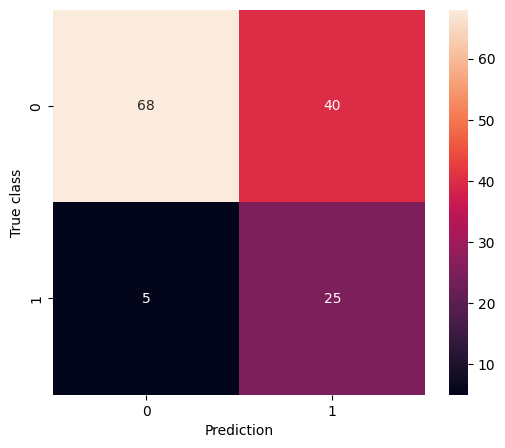

In [74]:
cm = confusion_matrix(message_val['burnout'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [75]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout'])

classification_report(message_val['burnout'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.85      0.61      0.71       108\n        True       0.30      0.60      0.40        30\n\n    accuracy                           0.61       138\n   macro avg       0.57      0.61      0.55       138\nweighted avg       0.73      0.61      0.64       138\n'

Text(45.722222222222214, 0.5, 'True class')

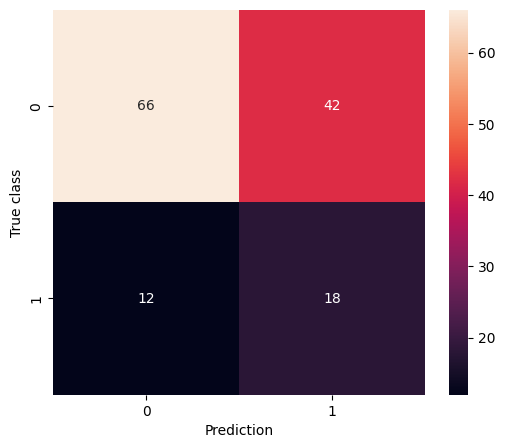

In [76]:
cm = confusion_matrix(message_val['burnout'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [77]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout'])

classification_report(message_val['burnout'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.86      0.64      0.73       108\n        True       0.33      0.63      0.43        30\n\n    accuracy                           0.64       138\n   macro avg       0.60      0.64      0.58       138\nweighted avg       0.75      0.64      0.67       138\n'

Text(45.722222222222214, 0.5, 'True class')

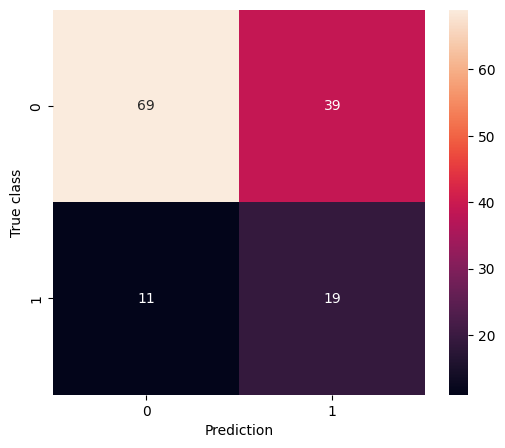

In [78]:
cm = confusion_matrix(message_val['burnout'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# RF models

In [79]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000)+1, max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(train_tf, message_train['burnout'])

classification_report(message_val['burnout'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.89      0.89      0.89       108\n        True       0.60      0.60      0.60        30\n\n    accuracy                           0.83       138\n   macro avg       0.74      0.74      0.74       138\nweighted avg       0.83      0.83      0.83       138\n'

Text(45.722222222222214, 0.5, 'True class')

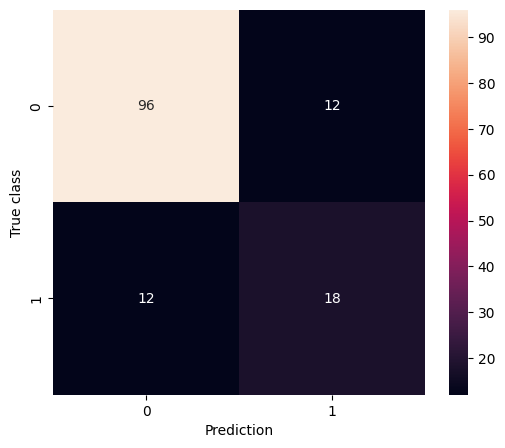

In [80]:
cm = confusion_matrix(message_val['burnout'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [81]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout'])

classification_report(message_val['burnout'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.92      0.70      0.80       108\n        True       0.42      0.77      0.54        30\n\n    accuracy                           0.72       138\n   macro avg       0.67      0.74      0.67       138\nweighted avg       0.81      0.72      0.74       138\n'

Text(45.722222222222214, 0.5, 'True class')

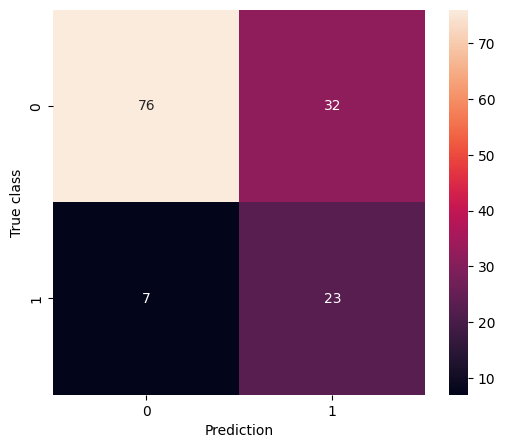

In [82]:
cm = confusion_matrix(message_val['burnout'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [83]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout'])

classification_report(message_val['burnout'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.88      0.86      0.87       108\n        True       0.53      0.57      0.55        30\n\n    accuracy                           0.80       138\n   macro avg       0.70      0.71      0.71       138\nweighted avg       0.80      0.80      0.80       138\n'

Text(45.722222222222214, 0.5, 'True class')

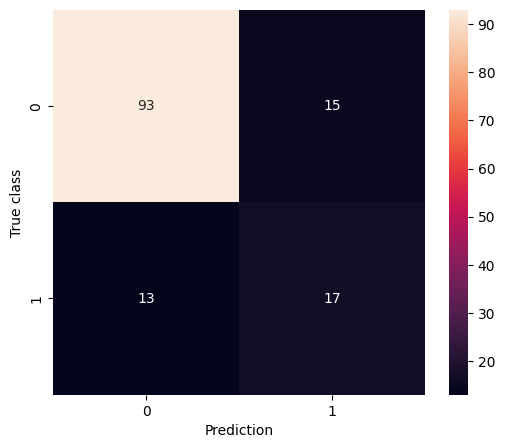

In [84]:
cm = confusion_matrix(message_val['burnout'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# Ragequit - LR

sklearn

In [34]:
burnout_logistic_data = logistic_data[~logistic_data['ragequit_t+1'].isna()].drop(['burnout_t+1', 'burnout_t+3', 'burnout_t+12', 'burnout', 'ragequit_t+3', 'ragequit_t+12', 'git_close'], axis = 1).drop_duplicates().drop(['Alias', 'From', 'To', 'start_datetime', 'end_datetime', 'lagged_burnout', 'reply_close', 'working_months', 'quit', 'first_quit_month', 'git_degree', 'Workload'], axis = 1).dropna().astype({'ragequit_t+1':bool})
logistic_train_data, logistic_test_data = train_test_split(burnout_logistic_data, test_size = 0.2, random_state = 404, stratify = burnout_logistic_data[['ragequit_t+1']])

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [35]:
burnout_logistic_data.describe(include = 'all')

,Avg. distance,Lone Wolf,Messages Sent,Organisational Silo,Radio Silence,standardized_workload,black_cloud,ragequit_t+1,st_congruence,reply_degree,reply_between,git_between,reply_density,git_density
count,162.000000,162,162.000000,162,162,162.000000,162,162,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000
unique,NaN,2,NaN,2,2,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,True,NaN,True,True,NaN,True,False,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,138,NaN,96,150,NaN,100,161,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.280967,NaN,18.234568,NaN,NaN,1.150713,NaN,NaN,0.266367,0.272046,0.166476,0.325876,0.154104,0.383010
std,1.007518,NaN,20.559728,NaN,NaN,1.793426,NaN,NaN,0.223167,0.121267,0.149141,0.267438,0.088754,0.180467
min,1.000000,NaN,1.000000,NaN,NaN,0.001583,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.044444
25%,1.666667,NaN,5.000000,NaN,NaN,0.182353,NaN,NaN,0.111111,0.181250,0.030183,0.156250,0.083333,0.250000
50%,2.000000,NaN,11.000000,NaN,NaN,0.469781,NaN,NaN,0.250000,0.288889,0.144101,0.240000,0.161905,0.377778
75%,2.729167,NaN,24.750000,NaN,NaN,1.418780,NaN,NaN,0.375000,0.352941,0.275148,0.481481,0.193910,0.500000


In [ ]:
lr_model = LogisticRegressionCV(max_iter = 1000000).fit(logistic_train_data.drop('ragequit_t+1', axis = 1), logistic_train_data['ragequit_t+1'])

In [ ]:
cm = confusion_matrix(logistic_test_data['ragequit_t+1'], lr_model.predict(logistic_test_data.drop('ragequit_t+1', axis = 1)))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

statsmodels

In [ ]:
stat_model = sm.Logit(logistic_train_data['ragequit_t+1'].astype(float), sm.add_constant(logistic_train_data.drop('ragequit_t+1', axis = 1)).astype(float)).fit(disp = 0)
stat_model.summary()

In [ ]:
cm = confusion_matrix(logistic_test_data['ragequit_t+1'], round(stat_model.predict(sm.add_constant(logistic_test_data.drop('ragequit_t+1', axis = 1)).astype(float))).astype(int))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

### Burnout NB

In [85]:
message_data = all_test[['reply_body', 'ragequit_t+1']].dropna()

nlp = spacy.load('en_core_web_sm')
tqdm.pandas()

message_data['lemmas'] = message_data.reply_body.progress_apply(lambda x: [token.lemma_ for token in nlp(handle_negation(x)) if not token.is_stop and token.is_alpha])
message_data['ragequit_t+1'] = message_data['ragequit_t+1'].astype(bool)
message_data

100%|██████████| 3604/3604 [01:40<00:00, 35.69it/s]


,reply_body,ragequit_t+1,lemmas
0,in we have scenario that there will be multipl...,False,"[scenario, multiple, helix, different, instanc..."
1,"if you are only repo to the code, can we use o...",False,"[repo, code, use, internal, repo, need, pr, wa..."
2,a single there are 4 can they be combined to one,False,"[single, combine]"
3,when writing to a using are corner cases they ...,False,"[write, corner, case, return, ticket, request,..."
5,could you rebase to the head?,False,"[rebase, head]"
...,...,...,...
4245,### issues - [x] my pr addresses the followin...,False,"[issue, x, pr, address, follow, helix, issuesr..."
4246,source code provided on the following the foll...,False,"[source, code, provide, follow, following, str..."
4247,@narendly thank i am contribution is,False,"[thank, contribution]"
4248,@narendly i am i am not sure i NegativeSentime...,False,"[narendly, NegativeSentiment, case, messagethe..."


In [86]:
message_data = message_data[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 0]

message_train, message_test = train_test_split(message_data, test_size=0.15, random_state=404, stratify = message_data['ragequit_t+1'])
message_train, message_val = train_test_split(message_train, test_size=(0.15/0.85), random_state=404, stratify = message_train['ragequit_t+1'])

print(f'length of train set: {len(message_train)}\nlength of validation set: {len(message_val)}\nlength of test set: {len(message_test)}')
message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages

# Oversample on the True cases in the train set
if 2*message_train["ragequit_t+1"].sum()<len(message_train):
   # True is the minority class
    if 3*message_train["ragequit_t+1"].sum()<len(message_train):
        # We need to over- and undersample to create balance
        message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+1"]==1].index], message_train])
        print(f'Positive cases: {message_train["ragequit_t+1"].sum()}')

        if 3*message_train["ragequit_t+1"].sum()<len(message_train):
            # Check for massive imbalance
            message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+1"]==1].index], message_train])
            print(f'Positive cases: {message_train["ragequit_t+1"].sum()}')

        nMax = message_train["ragequit_t+1"].sum()
        message_train = message_train.groupby("ragequit_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')
    else:
        nMax = message_train["ragequit_t+1"].sum()
        # Only undersampling will do
        print(f'Positive cases: {message_train["ragequit_t+1"].sum()}')
        message_train = message_train.groupby("ragequit_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')


else:
    if message_train["ragequit_t+1"].sum()>0.67*len(message_train):
        # False is the minority class and we need to over- and undersample
        message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+1"]==0].index], message_train])
        print(f'Positive cases: {message_train["ragequit_t+1"].sum()}')

        if message_train["ragequit_t+1"].sum()>0.67*len(message_train):
            # Check for massive imbalance (mainly ragequit case)
            message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+1"]==0].index], message_train])
            print(f'Positive cases: {message_train["ragequit_t+1"].sum()}')

        nMax = len(message_train) - message_train["ragequit_t+1"].sum()
        message_train = message_train.groupby("ragequit_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

    else:
        nMax = len(message_train) - message_train["ragequit_t+1"].sum()
        print(f'Positive cases: {message_train["ragequit_t+1"].sum()}')
        message_train = message_train.groupby("ragequit_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

length of train set: 2468
length of validation set: 529
length of test set: 530
Positive cases: 2
Positive cases: 6
New length of train set: 12


C:\Users\woute\AppData\Local\Temp\ipykernel_20520\1360335003.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages
C:\Users\woute\AppData\Local\Temp\ipykernel_20520\1360335003.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  message_train = message_train.groupby("ragequit_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)


In [87]:
pos_labels, pos_values = zip(*Counter(itertools.chain(*message_data[message_data['ragequit_t+1']].lemmas.tolist())).items())
neg_labels, neg_values = zip(*Counter(itertools.chain(*message_data[~message_data['ragequit_t+1']].lemmas.tolist())).items())

importance_df = pd.DataFrame(index = list(set(pos_labels + neg_labels)), data = {'pos_occur': pd.Series(pos_values, index = pos_labels), 'neg_occur': pd.Series(neg_values, index = neg_labels)})
importance_df.fillna(0, inplace = True)
importance_df['total_appearances'] = importance_df['pos_occur'] + importance_df['neg_occur']

for i in range(0,125,25):
    p = i
    importance_df['pos_importance'] = (importance_df['pos_occur'] + p)/(importance_df['total_appearances']+2*p)
    importance_df['neg_importance'] = (importance_df['neg_occur'] + p)/(importance_df['total_appearances']+2*p)
    print(f'positive {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'pos_importance', ascending = False)[['pos_importance', 'pos_occur', 'total_appearances']].head(20))
    print(f'negative {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'neg_importance', ascending = False)[['neg_importance', 'neg_occur', 'total_appearances']].head(20))
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

positive 0:
            pos_importance  pos_occur  total_appearances
session           0.010811        2.0              185.0
aware             0.008475        1.0              118.0
let               0.007353        1.0              136.0
client            0.006667        1.0              150.0
case              0.006579        1.0              152.0
different         0.005556        1.0              180.0
node              0.004902        1.0              204.0
log               0.003509        1.0              285.0
time              0.001627        2.0             1229.0
state             0.001235        1.0              810.0
good              0.001014        1.0              986.0
code              0.000880        1.0             1137.0
change            0.000750        1.0             1334.0
add               0.000490        2.0             4079.0
test              0.000344        2.0             5821.0
path              0.000000        0.0              139.0
distribute        0

In [88]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000)+1, max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = MultinomialNB()
classifier.fit(train_tf, message_train['ragequit_t+1'])

classification_report(message_val['ragequit_t+1'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       1.00      0.87      0.93       528\n        True       0.00      0.00      0.00         1\n\n    accuracy                           0.86       529\n   macro avg       0.50      0.43      0.46       529\nweighted avg       1.00      0.86      0.93       529\n'

Text(45.722222222222214, 0.5, 'True class')

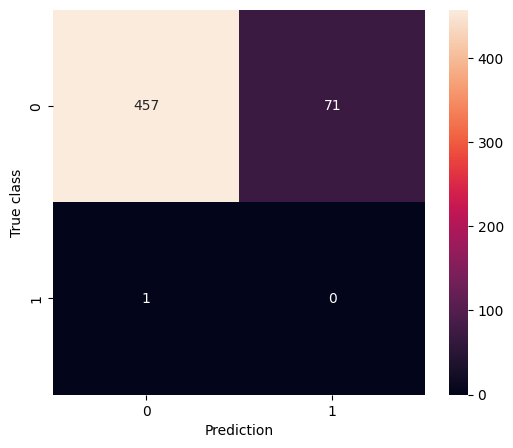

In [89]:
cm = confusion_matrix(message_val['ragequit_t+1'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [91]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_train.lemmas.to_list(), vector_size = 300, min_count = 5, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+1'])

classification_report(message_val['ragequit_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

'              precision    recall  f1-score   support\n\n       False       1.00      1.00      1.00       528\n        True       0.00      0.00      0.00         1\n\n    accuracy                           1.00       529\n   macro avg       0.50      0.50      0.50       529\nweighted avg       1.00      1.00      1.00       529\n'

Text(45.722222222222214, 0.5, 'True class')

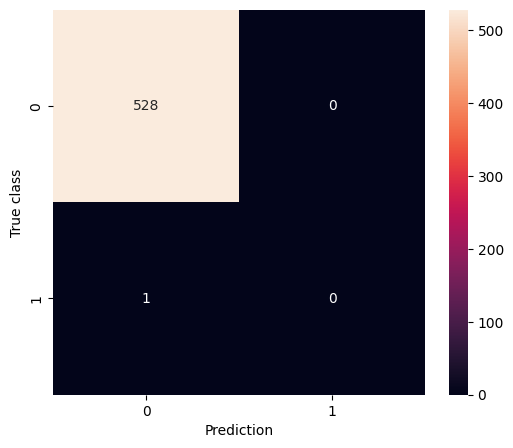

In [92]:
cm = confusion_matrix(message_val['ragequit_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [93]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+1'])

classification_report(message_val['ragequit_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

'              precision    recall  f1-score   support\n\n       False       1.00      1.00      1.00       528\n        True       0.00      0.00      0.00         1\n\n    accuracy                           1.00       529\n   macro avg       0.50      0.50      0.50       529\nweighted avg       1.00      1.00      1.00       529\n'

Text(45.722222222222214, 0.5, 'True class')

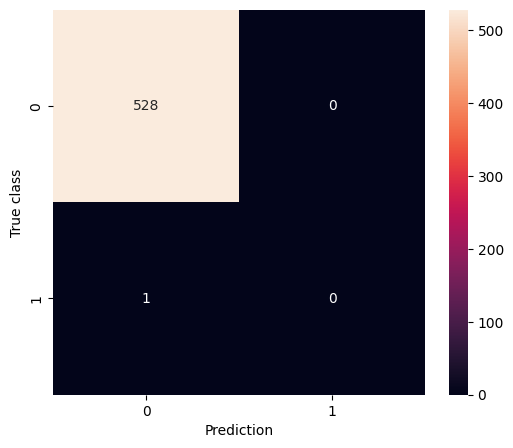

In [94]:
cm = confusion_matrix(message_val['ragequit_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# RF models

In [95]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000)+1, max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(train_tf, message_train['ragequit_t+1'])

classification_report(message_val['ragequit_t+1'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site

'              precision    recall  f1-score   support\n\n       False       1.00      1.00      1.00       528\n        True       0.00      0.00      0.00         1\n\n    accuracy                           1.00       529\n   macro avg       0.50      0.50      0.50       529\nweighted avg       1.00      1.00      1.00       529\n'

Text(45.722222222222214, 0.5, 'True class')

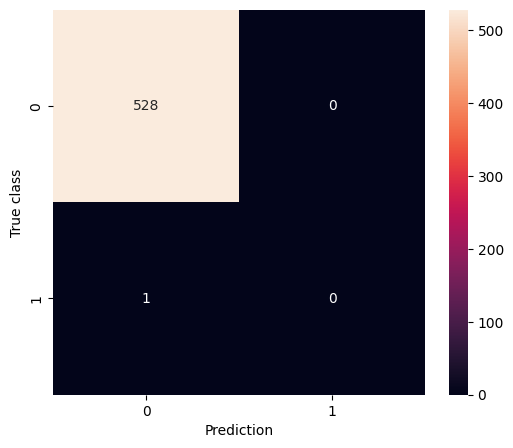

In [96]:
cm = confusion_matrix(message_val['ragequit_t+1'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [97]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_train.lemmas.to_list(), vector_size = 300, min_count = 5, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+1'])

classification_report(message_val['ragequit_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       1.00      0.55      0.71       528\n        True       0.00      1.00      0.01         1\n\n    accuracy                           0.55       529\n   macro avg       0.50      0.77      0.36       529\nweighted avg       1.00      0.55      0.70       529\n'

Text(45.722222222222214, 0.5, 'True class')

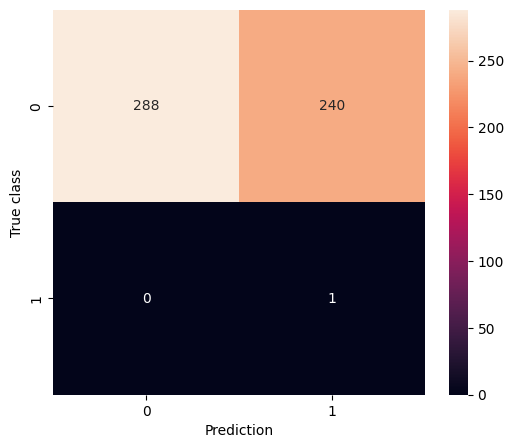

In [98]:
cm = confusion_matrix(message_val['ragequit_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [99]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+1'])

classification_report(message_val['ragequit_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       1.00      0.88      0.94       528\n        True       0.00      0.00      0.00         1\n\n    accuracy                           0.88       529\n   macro avg       0.50      0.44      0.47       529\nweighted avg       1.00      0.88      0.94       529\n'

Text(45.722222222222214, 0.5, 'True class')

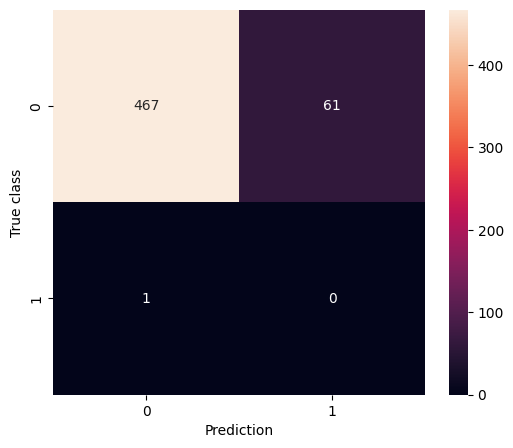

In [100]:
cm = confusion_matrix(message_val['ragequit_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# Lagged variables

## Burnout t+1

In [101]:
burnout_logistic_data = logistic_data[~logistic_data.burnout.isna()].drop(['burnout', 'burnout_t+3', 'burnout_t+12', 'ragequit_t+1', 'ragequit_t+3', 'ragequit_t+12', 'git_close'], axis = 1).drop_duplicates().drop(['Alias', 'From', 'To', 'start_datetime', 'end_datetime', 'lagged_burnout', 'reply_close', 'working_months', 'quit', 'first_quit_month', 'git_degree', 'Workload'], axis = 1).dropna().astype({'burnout_t+1':bool})
logistic_train_data, logistic_test_data = train_test_split(burnout_logistic_data, test_size = 0.2, random_state = 404, stratify = burnout_logistic_data['burnout_t+1'])


In [102]:
lr_model = LogisticRegressionCV(max_iter = 1000000).fit(logistic_train_data.drop('burnout_t+1', axis = 1), logistic_train_data['burnout_t+1'])

Text(45.722222222222214, 0.5, 'True class')

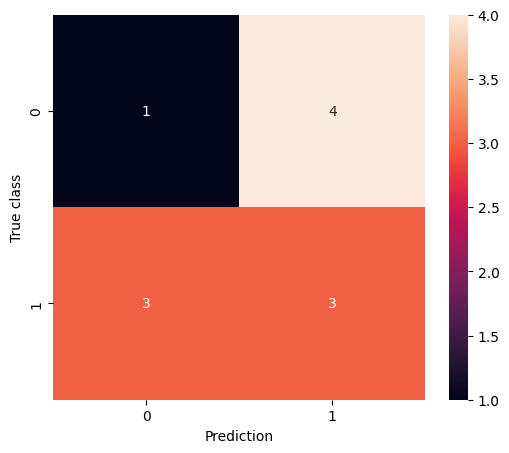

In [103]:
cm = confusion_matrix(logistic_test_data['burnout_t+1'], lr_model.predict(logistic_test_data.drop('burnout_t+1', axis = 1)))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

statsmodels

In [104]:
stat_model = sm.Logit(logistic_train_data['burnout_t+1'].astype(float), sm.add_constant(logistic_train_data.drop('burnout_t+1', axis = 1)).astype(float)).fit(disp = 0)
stat_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            burnout_t+1   No. Observations:                   40
Model:                          Logit   Df Residuals:                       26
Method:                           MLE   Df Model:                           13
Date:                Thu, 29 May 2025   Pseudo R-squ.:                  0.3264
Time:                        14:48:29   Log-Likelihood:                -18.677
converged:                       True   LL-Null:                       -27.726
Covariance Type:            nonrobust   LLR p-value:                    0.1539
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.0442      4.211      0.485      0.627      -6.209      10.297
Avg. distance            -0.9482      0.600     -1.579      0.114      -2.125       0.229
Lone Wolf                -0.2646      3.203     -0.083      0.934      -6.543       6.014
Messages Sent            -0.1745      0.079     -2.209      0.027      -0.329      -0.020
Organisational Silo      -0.8893      1.313     -0.677      0.498      -3.462       1.684
Radio Silence             0.1494      2.140      0.070      0.944      -4.045       4.344
standardized_workload    -1.2934      0.756     -1.711      0.087      -2.775       0.188
black_cloud               0.4362      1.191      0.366      0.714      -1.899       2.771
st_congruence             0.1349      4.879      0.028      0.978      -9.428       9.698
reply_degree             11.3997     10.945      1.042      0.298     -10.051      32.851
reply_between             4.7492      7.700      0.617      0.537     -10.343      19.841
git_between              -1.8571      2.404     -0.773      0.440      -6.568       2.854
reply_density             3.7314     11.024      0.338      0.735     -17.876      25.339
git_density               4.0969      3.828      1.070      0.285      -3.406      11.600
=========================================================================================
"""

Text(45.722222222222214, 0.5, 'True class')

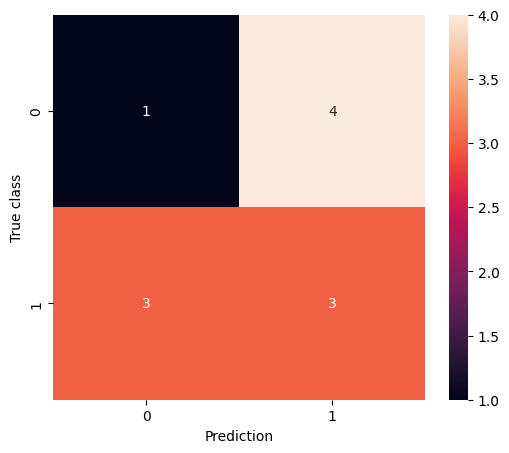

In [105]:
cm = confusion_matrix(logistic_test_data['burnout_t+1'], round(stat_model.predict(sm.add_constant(logistic_test_data.drop('burnout_t+1', axis = 1)).astype(float))).astype(int))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

### Burnout NB

In [106]:
message_data = all_test[['reply_body', 'burnout_t+1']].dropna()

nlp = spacy.load('en_core_web_sm')
tqdm.pandas()

message_data['lemmas'] = message_data.reply_body.progress_apply(lambda x: [token.lemma_ for token in nlp(handle_negation(x)) if not token.is_stop and token.is_alpha])
message_data['burnout_t+1'] = message_data['burnout_t+1'].astype(bool)
message_data

100%|██████████| 1032/1032 [00:25<00:00, 39.83it/s]


,reply_body,burnout_t+1,lemmas
0,in we have scenario that there will be multipl...,False,"[scenario, multiple, helix, different, instanc..."
8,has some he is on the fix so i am,True,[fix]
21,provide getresourceswithtaghelixadmin to retri...,True,"[provide, getresourceswithtaghelixadmin, retri..."
22,more details on the proposed solution is on th...,False,"[detail, propose, solution, jira]"
42,for we will ignore the only job resource will ...,False,"[ignore, job, resource, use, way, report, inst..."
...,...,...,...
4194,"this pr is ready to merge, approved commit",False,"[pr, ready, merge, approve, commit]"
4195,this pr is ready to be commit message: remove ...,False,"[pr, ready, commit, message, remove, unused, f..."
4199,### issues - [x] my pr addresses the following...,False,"[issue, x, pr, address, follow, helix, issuesr..."
4200,### issues - [x] my pr addresses the following...,False,"[issue, x, pr, address, follow, helix, issuesr..."


In [107]:
message_data = message_data[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 0]

message_train, message_test = train_test_split(message_data, test_size=0.15, random_state=404, stratify = message_data['burnout_t+1'])
message_train, message_val = train_test_split(message_train, test_size=(0.15/0.85), random_state=404, stratify = message_train['burnout_t+1'])

print(f'length of train set: {len(message_train)}\nlength of validation set: {len(message_val)}\nlength of test set: {len(message_test)}')
message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages

# Oversample on the True cases in the train set
if 2*message_train["burnout_t+1"].sum()<len(message_train):
   # True is the minority class
    if 3*message_train["burnout_t+1"].sum()<len(message_train):
        # We need to over- and undersample to create balance
        message_train = pd.concat([message_train.loc[message_train[message_train['burnout_t+1']==1].index], message_train])
        print(f'Positive cases: {message_train["burnout_t+1"].sum()}')

        if 3*message_train["burnout_t+1"].sum()<len(message_train):
            # Check for massive imbalance
            message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+1"]==1].index], message_train])
            print(f'Positive cases: {message_train["burnout_t+1"].sum()}')

        nMax = message_train["burnout_t+1"].sum()
        message_train = message_train.groupby("burnout_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')
    else:
        nMax = message_train["burnout_t+1"].sum()
        # Only undersampling will do
        print(f'Positive cases: {message_train["burnout_t+1"].sum()}')
        message_train = message_train.groupby("burnout_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')


else:
    if message_train["burnout_t+1"].sum()>0.67*len(message_train):
        # False is the minority class and we need to over- and undersample
        message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+1"]==0].index], message_train])
        print(f'Positive cases: {message_train["burnout_t+1"].sum()}')

        if message_train["burnout_t+1"].sum()>0.67*len(message_train):
            # Check for massive imbalance (mainly ragequit case)
            message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+1"]==0].index], message_train])
            print(f'Positive cases: {message_train["burnout_t+1"].sum()}')

        nMax = len(message_train) - message_train["burnout_t+1"].sum()
        message_train = message_train.groupby("burnout_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

    else:
        nMax = len(message_train) - message_train["burnout_t+1"].sum()
        print(f'Positive cases: {message_train["burnout_t+1"].sum()}')
        message_train = message_train.groupby("burnout_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

length of train set: 718
length of validation set: 154
length of test set: 155
Positive cases: 289
New length of train set: 578


C:\Users\woute\AppData\Local\Temp\ipykernel_20520\995443566.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages
C:\Users\woute\AppData\Local\Temp\ipykernel_20520\995443566.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  message_train = message_train.groupby("burnout_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)


In [108]:
pos_labels, pos_values = zip(*Counter(itertools.chain(*message_data[message_data['burnout_t+1']].lemmas.tolist())).items())
neg_labels, neg_values = zip(*Counter(itertools.chain(*message_data[~message_data['burnout_t+1']].lemmas.tolist())).items())

importance_df = pd.DataFrame(index = list(set(pos_labels + neg_labels)), data = {'pos_occur': pd.Series(pos_values, index = pos_labels), 'neg_occur': pd.Series(neg_values, index = neg_labels)})
importance_df.fillna(0, inplace = True)
importance_df['total_appearances'] = importance_df['pos_occur'] + importance_df['neg_occur']

for i in range(0,125,25):
    p = i
    importance_df['pos_importance'] = (importance_df['pos_occur'] + p)/(importance_df['total_appearances']+2*p)
    importance_df['neg_importance'] = (importance_df['neg_occur'] + p)/(importance_df['total_appearances']+2*p)
    print(f'positive {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'pos_importance', ascending = False)[['pos_importance', 'pos_occur', 'total_appearances']].head(20))
    print(f'negative {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'neg_importance', ascending = False)[['neg_importance', 'neg_occur', 'total_appearances']].head(20))
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

positive 0:
                 pos_importance  pos_occur  total_appearances
method                 0.679612       70.0              103.0
message                0.624697      258.0              413.0
cause                  0.622642       66.0              106.0
commitsthey            0.555556       70.0              126.0
squash                 0.555556       70.0              126.0
ready                  0.548673       62.0              113.0
rebalance              0.532710       57.0              107.0
module                 0.530303      105.0              198.0
line                   0.528000      264.0              500.0
state                  0.525362      145.0              276.0
address                0.517615      191.0              369.0
issue                  0.517493      355.0              686.0
issuesreference        0.504274      118.0              234.0
x                      0.502203      684.0             1362.0
themthe                0.502128      118.0              23

In [109]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000)+1, max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = MultinomialNB()
classifier.fit(train_tf, message_train['burnout_t+1'])

classification_report(message_val['burnout_t+1'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.67      0.55      0.61        85\n        True       0.55      0.67      0.60        69\n\n    accuracy                           0.60       154\n   macro avg       0.61      0.61      0.60       154\nweighted avg       0.62      0.60      0.60       154\n'

Text(45.722222222222214, 0.5, 'True class')

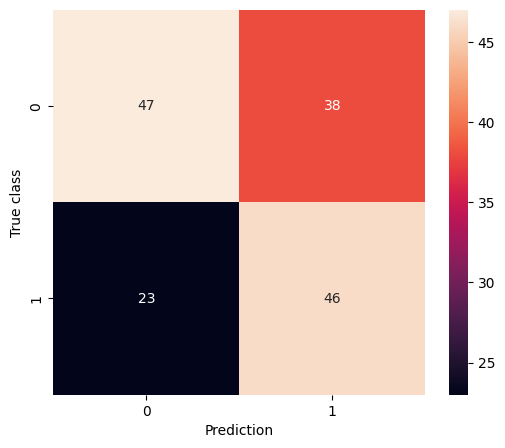

In [110]:
cm = confusion_matrix(message_val['burnout_t+1'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [111]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+1'])

classification_report(message_val['burnout_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.62      0.62      0.62        85\n        True       0.54      0.54      0.54        69\n\n    accuracy                           0.58       154\n   macro avg       0.58      0.58      0.58       154\nweighted avg       0.58      0.58      0.58       154\n'

Text(45.722222222222214, 0.5, 'True class')

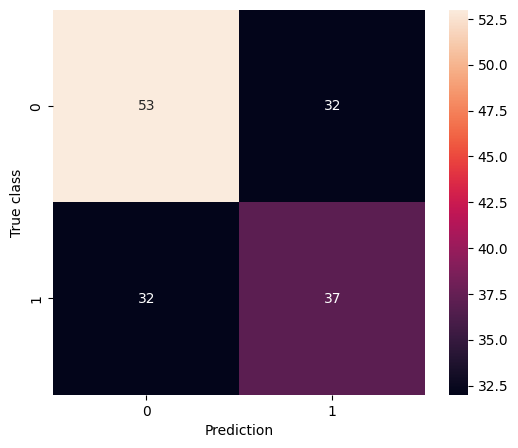

In [112]:
cm = confusion_matrix(message_val['burnout_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [113]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+1'])

classification_report(message_val['burnout_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.58      0.45      0.51        85\n        True       0.47      0.61      0.53        69\n\n    accuracy                           0.52       154\n   macro avg       0.53      0.53      0.52       154\nweighted avg       0.53      0.52      0.52       154\n'

Text(45.722222222222214, 0.5, 'True class')

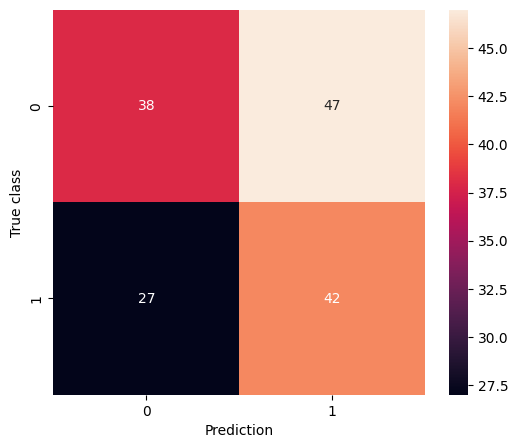

In [114]:
cm = confusion_matrix(message_val['burnout_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# RF models

In [115]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000), max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(train_tf, message_train['burnout_t+1'])

classification_report(message_val['burnout_t+1'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.66      0.74      0.70        85\n        True       0.63      0.54      0.58        69\n\n    accuracy                           0.65       154\n   macro avg       0.65      0.64      0.64       154\nweighted avg       0.65      0.65      0.65       154\n'

Text(45.722222222222214, 0.5, 'True class')

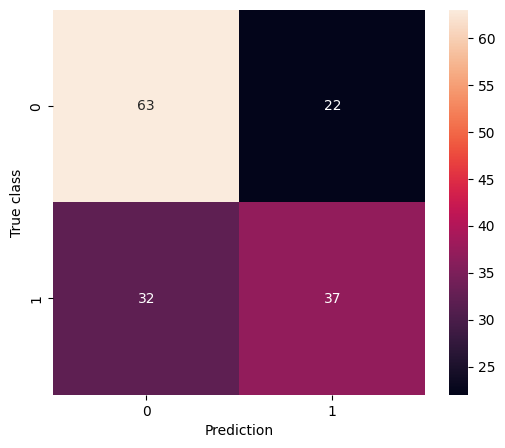

In [116]:
cm = confusion_matrix(message_val['burnout_t+1'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [117]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+1'])

classification_report(message_val['burnout_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.68      0.66      0.67        85\n        True       0.60      0.62      0.61        69\n\n    accuracy                           0.64       154\n   macro avg       0.64      0.64      0.64       154\nweighted avg       0.64      0.64      0.64       154\n'

Text(45.722222222222214, 0.5, 'True class')

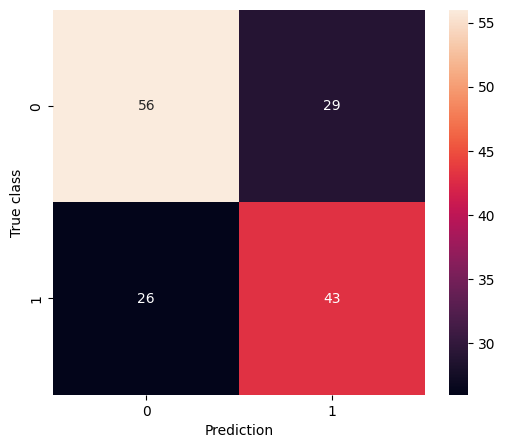

In [118]:
cm = confusion_matrix(message_val['burnout_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [119]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+1'])

classification_report(message_val['burnout_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.69      0.68      0.69        85\n        True       0.61      0.62      0.62        69\n\n    accuracy                           0.66       154\n   macro avg       0.65      0.65      0.65       154\nweighted avg       0.66      0.66      0.66       154\n'

Text(45.722222222222214, 0.5, 'True class')

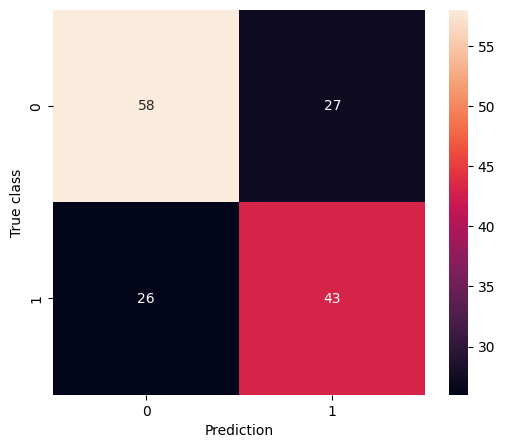

In [120]:
cm = confusion_matrix(message_val['burnout_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

## Burnout_t+3

In [121]:
burnout_logistic_data = logistic_data[~logistic_data.burnout.isna()].drop(['burnout_t+1', 'burnout', 'burnout_t+12', 'ragequit_t+1', 'ragequit_t+3', 'ragequit_t+12', 'git_close'], axis = 1).drop_duplicates().drop(['Alias', 'From', 'To', 'start_datetime', 'end_datetime', 'lagged_burnout', 'reply_close', 'working_months', 'quit', 'first_quit_month', 'git_degree', 'Workload'], axis = 1).dropna().astype({'burnout_t+3':bool})
logistic_train_data, logistic_test_data = train_test_split(burnout_logistic_data, test_size = 0.2, random_state = 404, stratify = burnout_logistic_data['burnout_t+3'])


In [122]:
lr_model = LogisticRegressionCV(max_iter = 1000000).fit(logistic_train_data.drop('burnout_t+3', axis = 1), logistic_train_data['burnout_t+3'])

Text(45.722222222222214, 0.5, 'True class')

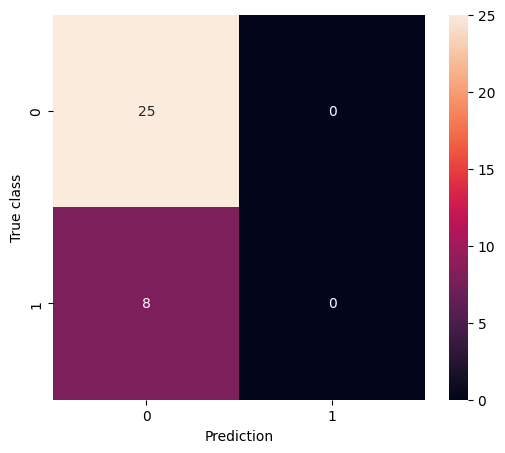

In [123]:
cm = confusion_matrix(logistic_test_data['burnout_t+3'], lr_model.predict(logistic_test_data.drop('burnout_t+3', axis = 1)))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

statsmodels

In [124]:
stat_model = sm.Logit(logistic_train_data['burnout_t+3'].astype(float), sm.add_constant(logistic_train_data.drop('burnout_t+3', axis = 1)).astype(float)).fit(disp = 0)
stat_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            burnout_t+3   No. Observations:                  129
Model:                          Logit   Df Residuals:                      115
Method:                           MLE   Df Model:                           13
Date:                Thu, 29 May 2025   Pseudo R-squ.:                  0.1499
Time:                        14:49:39   Log-Likelihood:                -62.357
converged:                       True   LL-Null:                       -73.354
Covariance Type:            nonrobust   LLR p-value:                   0.05548
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -1.1340      1.518     -0.747      0.455      -4.110       1.842
Avg. distance             0.2439      0.276      0.883      0.377      -0.297       0.785
Lone Wolf                -0.8710      0.909     -0.958      0.338      -2.653       0.911
Messages Sent            -0.0165      0.014     -1.144      0.253      -0.045       0.012
Organisational Silo      -0.6696      0.624     -1.074      0.283      -1.892       0.553
Radio Silence             0.7104      1.208      0.588      0.557      -1.658       3.079
standardized_workload     0.2984      0.125      2.391      0.017       0.054       0.543
black_cloud               1.4805      0.595      2.488      0.013       0.314       2.647
st_congruence             1.5124      1.418      1.067      0.286      -1.266       4.291
reply_degree             -2.6537      4.241     -0.626      0.532     -10.967       5.659
reply_between             1.7732      3.332      0.532      0.595      -4.758       8.305
git_between              -1.7342      1.020     -1.700      0.089      -3.734       0.266
reply_density            -6.0769      3.579     -1.698      0.090     -13.092       0.938
git_density               0.8264      1.491      0.554      0.579      -2.096       3.749
=========================================================================================
"""

Text(45.722222222222214, 0.5, 'True class')

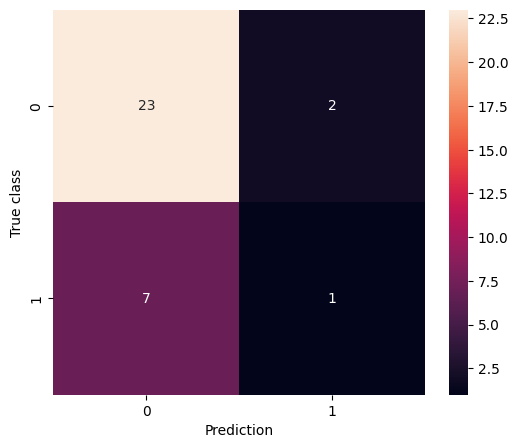

In [125]:
cm = confusion_matrix(logistic_test_data['burnout_t+3'], round(stat_model.predict(sm.add_constant(logistic_test_data.drop('burnout_t+3', axis = 1)).astype(float))).astype(int))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

### Burnout NB

In [9]:
message_data = all_test[['reply_body', 'burnout_t+3']].dropna()

nlp = spacy.load('en_core_web_sm')
tqdm.pandas()

message_data['lemmas'] = message_data.reply_body.progress_apply(lambda x: [token.lemma_ for token in nlp(handle_negation(x)) if not token.is_stop and token.is_alpha])
message_data['burnout_t+3'] = message_data['burnout_t+3'].astype(bool)
message_data

100%|██████████| 3604/3604 [01:41<00:00, 35.65it/s]


,reply_body,burnout_t+3,lemmas
0,in we have scenario that there will be multipl...,False,"[scenario, multiple, helix, different, instanc..."
1,"if you are only repo to the code, can we use o...",False,"[repo, code, use, internal, repo, need, pr, wa..."
2,a single there are 4 can they be combined to one,False,"[single, combine]"
3,when writing to a using are corner cases they ...,False,"[write, corner, case, return, ticket, request,..."
5,could you rebase to the head?,False,"[rebase, head]"
...,...,...,...
4245,### issues - [x] my pr addresses the followin...,False,"[issue, x, pr, address, follow, helix, issuesr..."
4246,source code provided on the following the foll...,False,"[source, code, provide, follow, following, str..."
4247,@narendly thank i am contribution is,False,"[thank, contribution]"
4248,@narendly i am i am not sure i NegativeSentime...,False,"[narendly, NegativeSentiment, case, messagethe..."


In [10]:
message_data = message_data[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 0]

message_train, message_test = train_test_split(message_data, test_size=0.15, random_state=404, stratify = message_data['burnout_t+3'])
message_train, message_val = train_test_split(message_train, test_size=(0.15/0.85), random_state=404, stratify = message_train['burnout_t+3'])

print(f'length of train set: {len(message_train)}\nlength of validation set: {len(message_val)}\nlength of test set: {len(message_test)}')
message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages

# Oversample on the True cases in the train set
if 2*message_train["burnout_t+3"].sum()<len(message_train):
   # True is the minority class
    if 3*message_train["burnout_t+3"].sum()<len(message_train):
        # We need to over- and undersample to create balance
        message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+3"]==1].index], message_train])
        print(f'Positive cases: {message_train["burnout_t+3"].sum()}')

        if 3*message_train["burnout_t+3"].sum()<len(message_train):
            # Check for massive imbalance
            message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+3"]==1].index], message_train])
            print(f'Positive cases: {message_train["burnout_t+3"].sum()}')

        nMax = message_train["burnout_t+3"].sum()
        message_train = message_train.groupby("burnout_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')
    else:
        nMax = message_train["burnout_t+3"].sum()
        # Only undersampling will do
        print(f'Positive cases: {message_train["burnout_t+3"].sum()}')
        message_train = message_train.groupby("burnout_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')


else:
    if message_train["burnout_t+3"].sum()>0.67*len(message_train):
        # False is the minority class and we need to over- and undersample
        message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+3"]==0].index], message_train])
        print(f'Positive cases: {message_train["burnout_t+3"].sum()}')

        if message_train["burnout_t+3"].sum()>0.67*len(message_train):
            # Check for massive imbalance (mainly ragequit case)
            message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+3"]==0].index], message_train])
            print(f'Positive cases: {message_train["burnout_t+3"].sum()}')

        nMax = len(message_train) - message_train["burnout_t+3"].sum()
        message_train = message_train.groupby("burnout_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

    else:
        nMax = len(message_train) - message_train["burnout_t+3"].sum()
        print(f'Positive cases: {message_train["burnout_t+3"].sum()}')
        message_train = message_train.groupby("burnout_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

length of train set: 2468
length of validation set: 529
length of test set: 530
Positive cases: 1020
New length of train set: 2040


C:\Users\woute\AppData\Local\Temp\ipykernel_20520\1913014158.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages
C:\Users\woute\AppData\Local\Temp\ipykernel_20520\1913014158.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  message_train = message_train.groupby("burnout_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)


In [11]:
pos_labels, pos_values = zip(*Counter(itertools.chain(*message_data[message_data['burnout_t+3']].lemmas.tolist())).items())
neg_labels, neg_values = zip(*Counter(itertools.chain(*message_data[~message_data['burnout_t+3']].lemmas.tolist())).items())

importance_df = pd.DataFrame(index = list(set(pos_labels + neg_labels)), data = {'pos_occur': pd.Series(pos_values, index = pos_labels), 'neg_occur': pd.Series(neg_values, index = neg_labels)})
importance_df.fillna(0, inplace = True)
importance_df['total_appearances'] = importance_df['pos_occur'] + importance_df['neg_occur']

for i in range(0,125,25):
    p = i
    importance_df['pos_importance'] = (importance_df['pos_occur'] + p)/(importance_df['total_appearances']+2*p)
    importance_df['neg_importance'] = (importance_df['neg_occur'] + p)/(importance_df['total_appearances']+2*p)
    print(f'positive {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'pos_importance', ascending = False)[['pos_importance', 'pos_occur', 'total_appearances']].head(20))
    print(f'negative {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'neg_importance', ascending = False)[['neg_importance', 'neg_occur', 'total_appearances']].head(20))
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

positive 0:
             pos_importance  pos_occur  total_appearances
na                 0.771930       88.0              114.0
rebalancer         0.551724      144.0              261.0
lock               0.544379       92.0              169.0
transition         0.531915       75.0              141.0
wage               0.516340       79.0              153.0
rebalance          0.435556       98.0              225.0
customize          0.417266       58.0              139.0
well               0.416667       45.0              108.0
feature            0.412281       47.0              114.0
commitsthey        0.408377      156.0              382.0
squash             0.406250      156.0              384.0
design             0.403509       46.0              114.0
avoid              0.401515       53.0              132.0
previous           0.396040       40.0              101.0
different          0.377778       68.0              180.0
replica            0.372973       69.0              185.0
mu

In [12]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000), max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = MultinomialNB()
classifier.fit(train_tf, message_train['burnout_t+3'])

classification_report(message_val['burnout_t+3'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.87      0.69      0.77       401\n        True       0.42      0.69      0.52       128\n\n    accuracy                           0.69       529\n   macro avg       0.64      0.69      0.64       529\nweighted avg       0.76      0.69      0.71       529\n'

Text(45.722222222222214, 0.5, 'True class')

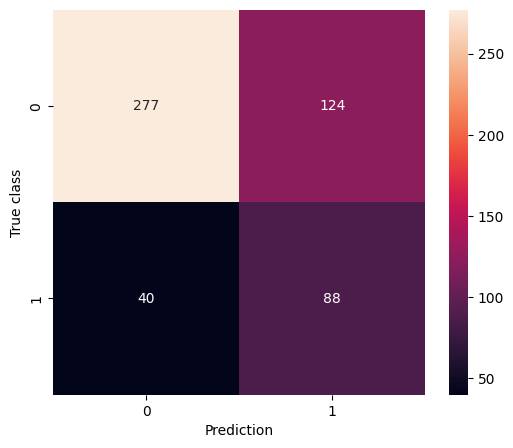

In [13]:
cm = confusion_matrix(message_val['burnout_t+3'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [14]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+3'])

classification_report(message_val['burnout_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.80      0.65      0.71       401\n        True       0.31      0.49      0.38       128\n\n    accuracy                           0.61       529\n   macro avg       0.55      0.57      0.55       529\nweighted avg       0.68      0.61      0.63       529\n'

Text(45.722222222222214, 0.5, 'True class')

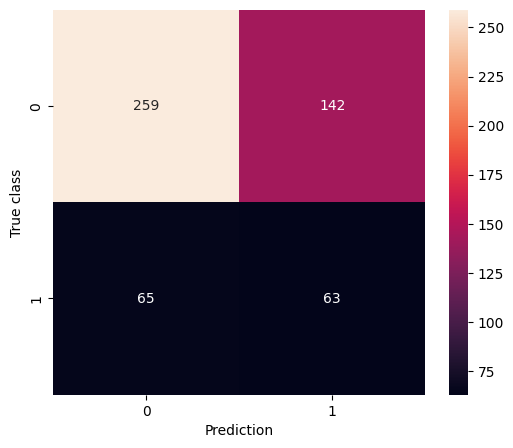

In [15]:
cm = confusion_matrix(message_val['burnout_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [16]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+3'])

classification_report(message_val['burnout_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.77      0.64      0.70       401\n        True       0.26      0.40      0.31       128\n\n    accuracy                           0.58       529\n   macro avg       0.51      0.52      0.51       529\nweighted avg       0.65      0.58      0.60       529\n'

Text(45.722222222222214, 0.5, 'True class')

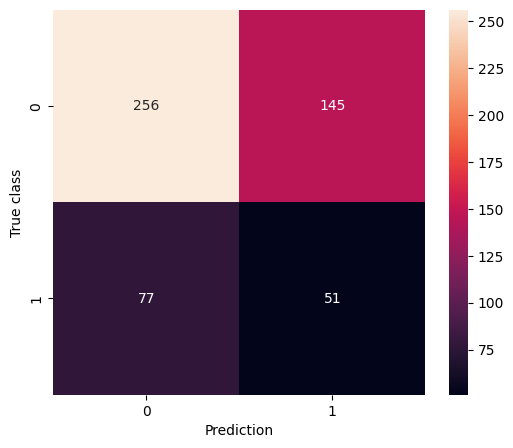

In [17]:
cm = confusion_matrix(message_val['burnout_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# RF models

In [18]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000), max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(train_tf, message_train['burnout_t+3'])

classification_report(message_val['burnout_t+3'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.85      0.87      0.86       401\n        True       0.55      0.51      0.53       128\n\n    accuracy                           0.78       529\n   macro avg       0.70      0.69      0.69       529\nweighted avg       0.77      0.78      0.78       529\n'

Text(45.722222222222214, 0.5, 'True class')

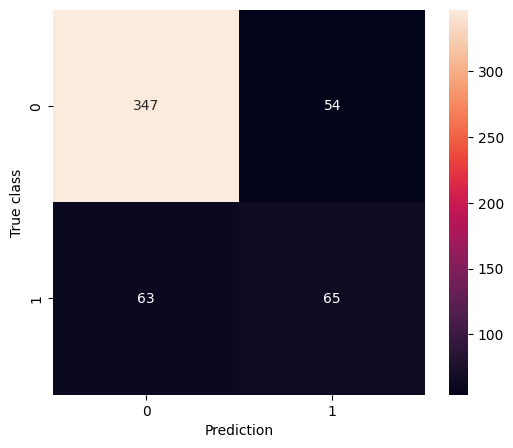

In [19]:
cm = confusion_matrix(message_val['burnout_t+3'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [20]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+3'])

classification_report(message_val['burnout_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.84      0.89      0.86       401\n        True       0.57      0.46      0.51       128\n\n    accuracy                           0.79       529\n   macro avg       0.71      0.68      0.69       529\nweighted avg       0.77      0.79      0.78       529\n'

Text(45.722222222222214, 0.5, 'True class')

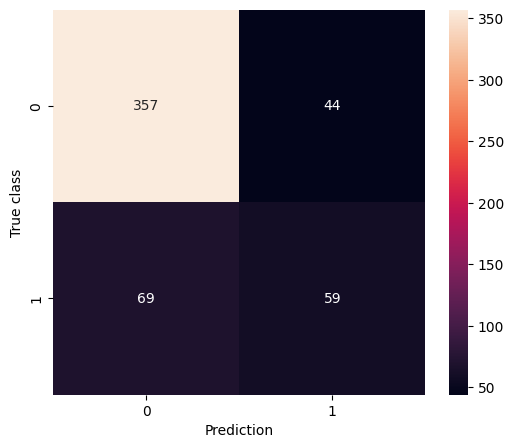

In [21]:
cm = confusion_matrix(message_val['burnout_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [22]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+3'])

classification_report(message_val['burnout_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.83      0.93      0.88       401\n        True       0.64      0.42      0.51       128\n\n    accuracy                           0.80       529\n   macro avg       0.74      0.67      0.69       529\nweighted avg       0.79      0.80      0.79       529\n'

Text(45.722222222222214, 0.5, 'True class')

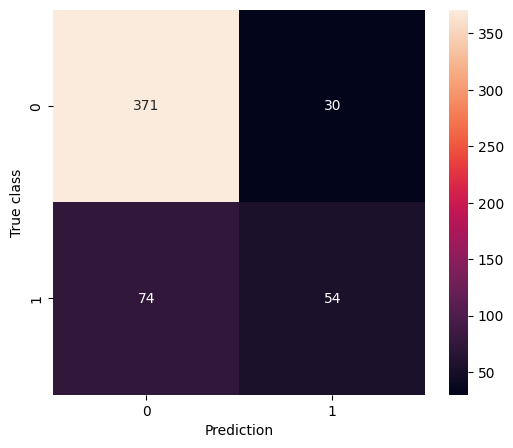

In [23]:
cm = confusion_matrix(message_val['burnout_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

## Burnout T+12

In [126]:
burnout_logistic_data = logistic_data[~logistic_data.burnout.isna()].drop(['burnout_t+1', 'burnout_t+3', 'burnout', 'ragequit_t+1', 'ragequit_t+3', 'ragequit_t+12', 'git_close'], axis = 1).drop_duplicates().drop(['Alias', 'From', 'To', 'start_datetime', 'end_datetime', 'lagged_burnout', 'reply_close', 'working_months', 'quit', 'first_quit_month', 'git_degree', 'Workload'], axis = 1).dropna().astype({'burnout_t+12':bool})
logistic_train_data, logistic_test_data = train_test_split(burnout_logistic_data, test_size = 0.2, random_state = 404, stratify = burnout_logistic_data['burnout_t+12'])

In [127]:
lr_model = LogisticRegressionCV(max_iter = 1000000).fit(logistic_train_data.drop('burnout_t+12', axis = 1), logistic_train_data['burnout_t+12'])

Text(45.722222222222214, 0.5, 'True class')

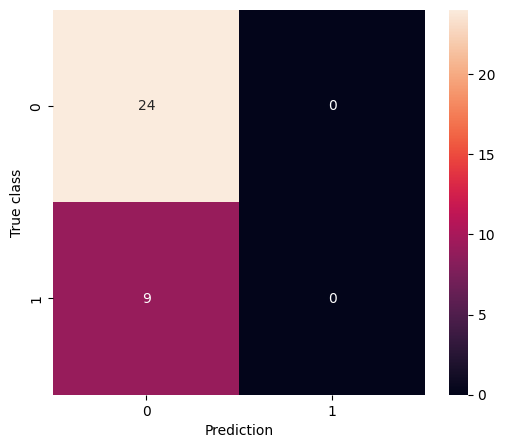

In [128]:
cm = confusion_matrix(logistic_test_data['burnout_t+12'], lr_model.predict(logistic_test_data.drop('burnout_t+12', axis = 1)))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

statsmodels

In [129]:
stat_model = sm.Logit(logistic_train_data['burnout_t+12'].astype(float), sm.add_constant(logistic_train_data.drop('burnout_t+12', axis = 1)).astype(float)).fit(disp = 0)
stat_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           burnout_t+12   No. Observations:                  129
Model:                          Logit   Df Residuals:                      115
Method:                           MLE   Df Model:                           13
Date:                Thu, 29 May 2025   Pseudo R-squ.:                  0.1193
Time:                        14:50:30   Log-Likelihood:                -64.601
converged:                       True   LL-Null:                       -73.354
Covariance Type:            nonrobust   LLR p-value:                    0.1772
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -1.2769      1.505     -0.848      0.396      -4.226       1.673
Avg. distance             0.3400      0.266      1.280      0.200      -0.180       0.860
Lone Wolf                -0.9546      0.963     -0.991      0.322      -2.842       0.933
Messages Sent            -0.0003      0.016     -0.021      0.983      -0.032       0.031
Organisational Silo      -0.4506      0.585     -0.771      0.441      -1.597       0.696
Radio Silence             1.1696      1.194      0.980      0.327      -1.170       3.509
standardized_workload     0.2136      0.115      1.862      0.063      -0.011       0.438
black_cloud               1.0171      0.552      1.843      0.065      -0.065       2.099
st_congruence             2.0827      1.449      1.437      0.151      -0.758       4.923
reply_degree             -4.7048      4.207     -1.118      0.263     -12.950       3.540
reply_between            -0.0639      3.281     -0.019      0.984      -6.495       6.367
git_between              -0.9360      0.958     -0.977      0.328      -2.813       0.941
reply_density            -2.4449      3.236     -0.755      0.450      -8.788       3.898
git_density              -0.3302      1.511     -0.219      0.827      -3.291       2.631
=========================================================================================
"""

Text(45.722222222222214, 0.5, 'True class')

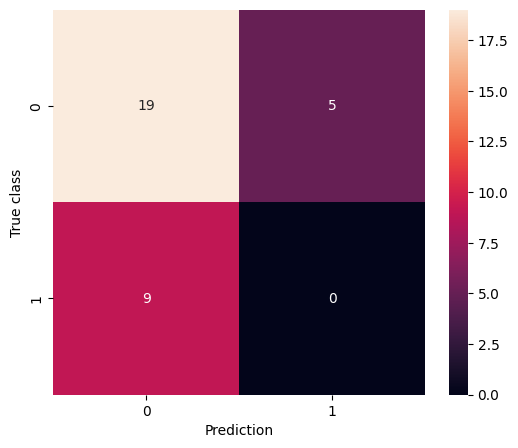

In [130]:
cm = confusion_matrix(logistic_test_data['burnout_t+12'], round(stat_model.predict(sm.add_constant(logistic_test_data.drop('burnout_t+12', axis = 1)).astype(float))).astype(int))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

### Burnout NB

In [24]:
message_data = all_test[['reply_body', 'burnout_t+12']].dropna()

nlp = spacy.load('en_core_web_sm')
tqdm.pandas()

message_data['lemmas'] = message_data.reply_body.progress_apply(lambda x: [token.lemma_ for token in nlp(handle_negation(x)) if not token.is_stop and token.is_alpha])
message_data['burnout_t+12'] = message_data['burnout_t+12'].astype(bool)
message_data

100%|██████████| 3604/3604 [01:35<00:00, 37.77it/s]


,reply_body,burnout_t+12,lemmas
0,in we have scenario that there will be multipl...,False,"[scenario, multiple, helix, different, instanc..."
1,"if you are only repo to the code, can we use o...",False,"[repo, code, use, internal, repo, need, pr, wa..."
2,a single there are 4 can they be combined to one,False,"[single, combine]"
3,when writing to a using are corner cases they ...,False,"[write, corner, case, return, ticket, request,..."
5,could you rebase to the head?,False,"[rebase, head]"
...,...,...,...
4245,### issues - [x] my pr addresses the followin...,False,"[issue, x, pr, address, follow, helix, issuesr..."
4246,source code provided on the following the foll...,False,"[source, code, provide, follow, following, str..."
4247,@narendly thank i am contribution is,False,"[thank, contribution]"
4248,@narendly i am i am not sure i NegativeSentime...,False,"[narendly, NegativeSentiment, case, messagethe..."


In [25]:
message_data = message_data[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 0]

message_train, message_test = train_test_split(message_data, test_size=0.15, random_state=404, stratify = message_data['burnout_t+12'])
message_train, message_val = train_test_split(message_train, test_size=(0.15/0.85), random_state=404, stratify = message_train['burnout_t+12'])

print(f'length of train set: {len(message_train)}\nlength of validation set: {len(message_val)}\nlength of test set: {len(message_test)}')
message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages

# Oversample on the True cases in the train set
if 2*message_train["burnout_t+12"].sum()<len(message_train):
   # True is the minority class
    if 3*message_train["burnout_t+12"].sum()<len(message_train):
        # We need to over- and undersample to create balance
        message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+12"]==1].index], message_train])
        print(f'Positive cases: {message_train["burnout_t+12"].sum()}')

        if 3*message_train["burnout_t+12"].sum()<len(message_train):
            # Check for massive imbalance
            message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+12"]==1].index], message_train])
            print(f'Positive cases: {message_train["burnout_t+12"].sum()}')

        nMax = message_train["burnout_t+12"].sum()
        message_train = message_train.groupby("burnout_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')
    else:
        nMax = message_train["burnout_t+12"].sum()
        # Only undersampling will do
        print(f'Positive cases: {message_train["burnout_t+12"].sum()}')
        message_train = message_train.groupby("burnout_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')


else:
    if message_train["burnout_t+12"].sum()>0.67*len(message_train):
        # False is the minority class and we need to over- and undersample
        message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+12"]==0].index], message_train])
        print(f'Positive cases: {message_train["burnout_t+12"].sum()}')

        if message_train["burnout_t+12"].sum()>0.67*len(message_train):
            # Check for massive imbalance (mainly ragequit case)
            message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+12"]==0].index], message_train])
            print(f'Positive cases: {message_train["burnout_t+12"].sum()}')

        nMax = len(message_train) - message_train["burnout_t+12"].sum()
        message_train = message_train.groupby("burnout_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

    else:
        nMax = len(message_train) - message_train["burnout_t+12"].sum()
        print(f'Positive cases: {message_train["burnout_t+12"].sum()}')
        message_train = message_train.groupby("burnout_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

C:\Users\woute\AppData\Local\Temp\ipykernel_20520\188543492.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages
C:\Users\woute\AppData\Local\Temp\ipykernel_20520\188543492.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  message_train = message_train.groupby("burnout_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)


length of train set: 2468
length of validation set: 529
length of test set: 530
Positive cases: 1132
New length of train set: 2264


In [26]:
pos_labels, pos_values = zip(*Counter(itertools.chain(*message_data[message_data['burnout_t+12']].lemmas.tolist())).items())
neg_labels, neg_values = zip(*Counter(itertools.chain(*message_data[~message_data['burnout_t+12']].lemmas.tolist())).items())

importance_df = pd.DataFrame(index = list(set(pos_labels + neg_labels)), data = {'pos_occur': pd.Series(pos_values, index = pos_labels), 'neg_occur': pd.Series(neg_values, index = neg_labels)})
importance_df.fillna(0, inplace = True)
importance_df['total_appearances'] = importance_df['pos_occur'] + importance_df['neg_occur']

for i in range(0,125,25):
    p = i
    importance_df['pos_importance'] = (importance_df['pos_occur'] + p)/(importance_df['total_appearances']+2*p)
    importance_df['neg_importance'] = (importance_df['neg_occur'] + p)/(importance_df['total_appearances']+2*p)
    print(f'positive {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'pos_importance', ascending = False)[['pos_importance', 'pos_occur', 'total_appearances']].head(20))
    print(f'negative {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'neg_importance', ascending = False)[['neg_importance', 'neg_occur', 'total_appearances']].head(20))
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

positive 0:
             pos_importance  pos_occur  total_appearances
na                 0.824561       94.0              114.0
rebalancer         0.636015      166.0              261.0
wage               0.568627       87.0              153.0
lock               0.568047       96.0              169.0
transition         0.531915       75.0              141.0
design             0.517544       59.0              114.0
rebalance          0.488889      110.0              225.0
feature            0.456140       52.0              114.0
previous           0.455446       46.0              101.0
avoid              0.454545       60.0              132.0
well               0.453704       49.0              108.0
commitsthey        0.429319      164.0              382.0
squash             0.427083      164.0              384.0
customize          0.417266       58.0              139.0
different          0.405556       73.0              180.0
distribute         0.400000       72.0              180.0
re

In [27]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000), max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = MultinomialNB()
classifier.fit(train_tf, message_train['burnout_t+12'])

classification_report(message_val['burnout_t+12'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.91      0.69      0.78       388\n        True       0.49      0.81      0.61       141\n\n    accuracy                           0.72       529\n   macro avg       0.70      0.75      0.70       529\nweighted avg       0.80      0.72      0.74       529\n'

Text(45.722222222222214, 0.5, 'True class')

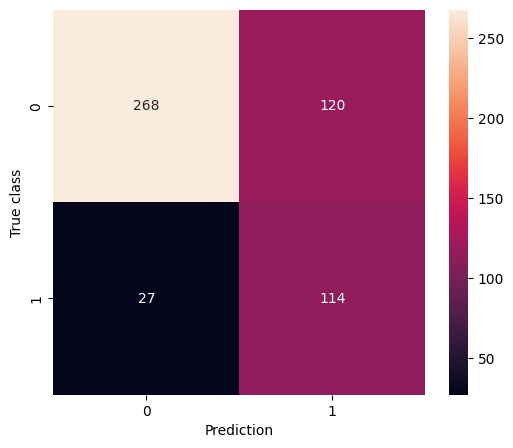

In [28]:
cm = confusion_matrix(message_val['burnout_t+12'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [29]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+12'])

classification_report(message_val['burnout_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.79      0.57      0.66       388\n        True       0.33      0.59      0.42       141\n\n    accuracy                           0.57       529\n   macro avg       0.56      0.58      0.54       529\nweighted avg       0.67      0.57      0.60       529\n'

Text(45.722222222222214, 0.5, 'True class')

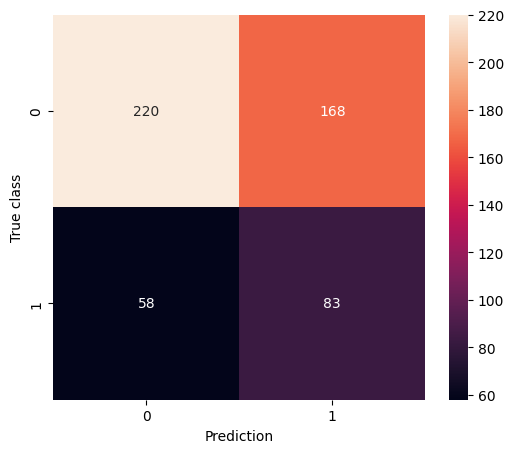

In [30]:
cm = confusion_matrix(message_val['burnout_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [31]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+12'])

classification_report(message_val['burnout_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.77      0.52      0.62       388\n        True       0.30      0.57      0.40       141\n\n    accuracy                           0.53       529\n   macro avg       0.54      0.55      0.51       529\nweighted avg       0.65      0.53      0.56       529\n'

Text(45.722222222222214, 0.5, 'True class')

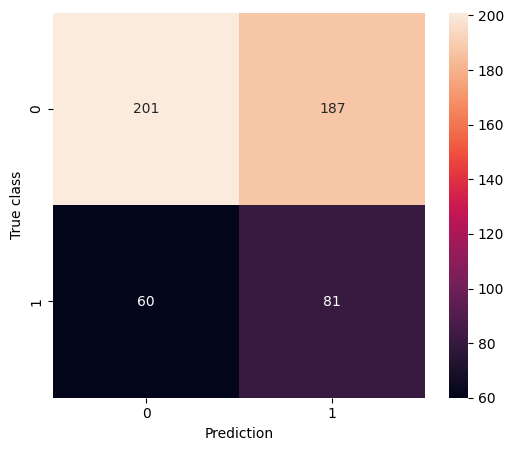

In [32]:
cm = confusion_matrix(message_val['burnout_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# RF models

In [33]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000), max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(train_tf, message_train['burnout_t+12'])

classification_report(message_val['burnout_t+12'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.86      0.86      0.86       388\n        True       0.61      0.61      0.61       141\n\n    accuracy                           0.79       529\n   macro avg       0.73      0.73      0.73       529\nweighted avg       0.79      0.79      0.79       529\n'

Text(45.722222222222214, 0.5, 'True class')

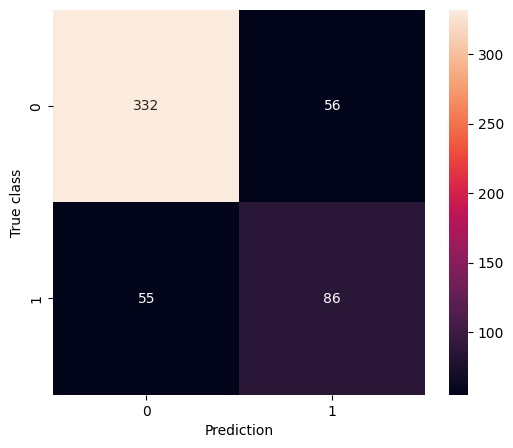

In [34]:
cm = confusion_matrix(message_val['burnout_t+12'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [35]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+12'])

classification_report(message_val['burnout_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.84      0.89      0.87       388\n        True       0.64      0.54      0.59       141\n\n    accuracy                           0.80       529\n   macro avg       0.74      0.72      0.73       529\nweighted avg       0.79      0.80      0.79       529\n'

Text(45.722222222222214, 0.5, 'True class')

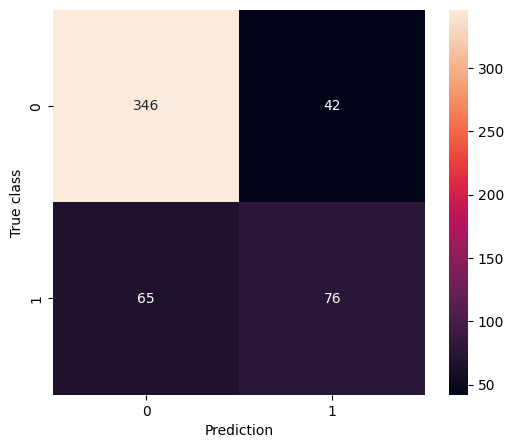

In [36]:
cm = confusion_matrix(message_val['burnout_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [37]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+12'])

classification_report(message_val['burnout_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.83      0.93      0.87       388\n        True       0.70      0.46      0.56       141\n\n    accuracy                           0.80       529\n   macro avg       0.76      0.69      0.71       529\nweighted avg       0.79      0.80      0.79       529\n'

Text(45.722222222222214, 0.5, 'True class')

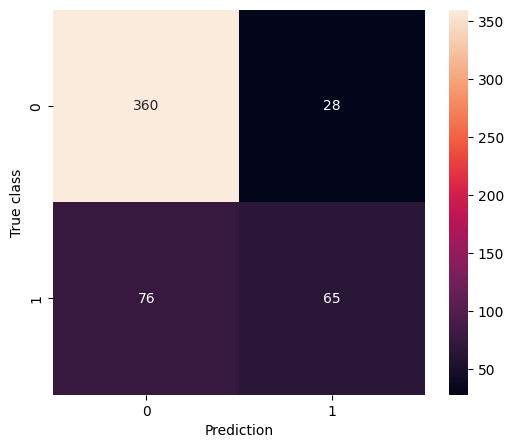

In [38]:
cm = confusion_matrix(message_val['burnout_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

## Ragequit T+3

In [136]:
burnout_logistic_data = logistic_data[~logistic_data.burnout.isna()].drop(['burnout_t+1', 'burnout_t+3', 'burnout_t+12', 'ragequit_t+1', 'burnout', 'ragequit_t+12', 'git_close'], axis = 1).drop_duplicates().drop(['Alias', 'From', 'To', 'start_datetime', 'end_datetime', 'lagged_burnout', 'reply_close', 'working_months', 'quit', 'first_quit_month', 'Workload'], axis = 1).dropna().astype({'ragequit_t+3':bool})
logistic_train_data, logistic_test_data = train_test_split(burnout_logistic_data, test_size = 0.2, random_state = 404, stratify = burnout_logistic_data['ragequit_t+3'])


In [137]:
lr_model = LogisticRegressionCV(max_iter = 1000000).fit(logistic_train_data.drop('ragequit_t+3', axis = 1), logistic_train_data['ragequit_t+3'])

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Text(45.722222222222214, 0.5, 'True class')

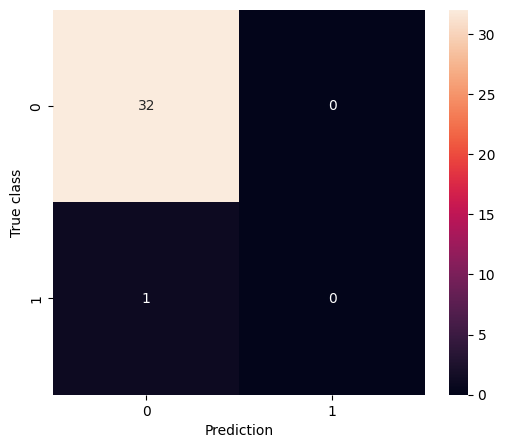

In [138]:
cm = confusion_matrix(logistic_test_data['ragequit_t+3'], lr_model.predict(logistic_test_data.drop('ragequit_t+3', axis = 1)))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

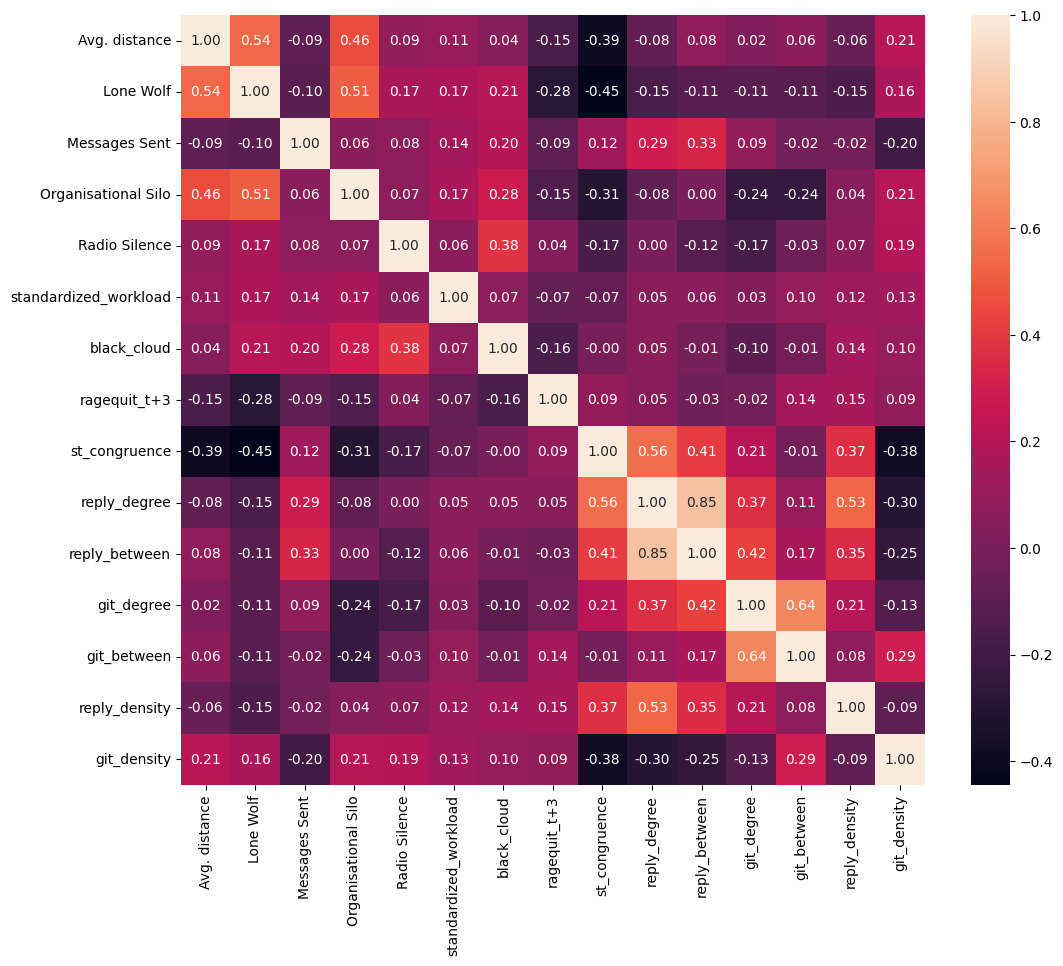

In [139]:
fig = plt.figure(figsize=(12,10))
ax= plt.subplot()
sns.heatmap(logistic_train_data.astype(float).corr(), annot=True, ax = ax, fmt = '.2f');

In [140]:
logistic_train_data.describe(include = 'all')

,Avg. distance,Lone Wolf,Messages Sent,Organisational Silo,Radio Silence,standardized_workload,black_cloud,ragequit_t+3,st_congruence,reply_degree,reply_between,git_degree,git_between,reply_density,git_density
count,129.000000,129,129.000000,129,129,129.000000,129,129,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
unique,NaN,2,NaN,2,2,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,True,NaN,True,True,NaN,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,108,NaN,74,118,NaN,79,127,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.226375,NaN,18.589147,NaN,NaN,1.211659,NaN,NaN,0.286093,0.273081,0.168922,0.319930,0.328209,0.150340,0.377569
std,1.004884,NaN,21.222266,NaN,NaN,1.913085,NaN,NaN,0.222748,0.122530,0.151275,0.121751,0.264677,0.089963,0.177624
min,1.000000,NaN,1.000000,NaN,NaN,0.001583,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.044444
25%,1.666667,NaN,5.000000,NaN,NaN,0.141735,NaN,NaN,0.142857,0.180556,0.029827,0.250000,0.156250,0.076190,0.250000
50%,2.000000,NaN,11.000000,NaN,NaN,0.532593,NaN,NaN,0.250000,0.288889,0.149660,0.305556,0.240000,0.147059,0.333333
75%,2.500000,NaN,25.000000,NaN,NaN,1.460014,NaN,NaN,0.400000,0.352941,0.275148,0.400000,0.481481,0.192308,0.464286


statsmodels

In [141]:
stat_model = sm.Logit(logistic_train_data['ragequit_t+3'].astype(float), sm.add_constant(logistic_train_data[['Avg. distance', 'Lone Wolf', 'standardized_workload',
 'Organisational Silo', 'Radio Silence',  'black_cloud']]).astype(float)).fit(disp = 0)
stat_model.summary()

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           ragequit_t+3   No. Observations:                  129
Model:                          Logit   Df Residuals:                      122
Method:                           MLE   Df Model:                            6
Date:                Thu, 29 May 2025   Pseudo R-squ.:                  0.5770
Time:                        14:52:00   Log-Likelihood:                -4.3642
converged:                      False   LL-Null:                       -10.318
Covariance Type:            nonrobust   LLR p-value:                   0.06407
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -15.0211   1.54e+07  -9.76e-07      1.000   -3.02e+07    3.02e+07
Avg. distance            -5.4563   1.54e+07  -3.55e-07      1.000   -3.02e+07    3.02e+07
Lone Wolf               -26.8491   1.13e+07  -2.37e-06      1.000   -2.22e+07    2.22e+07
standardized_workload    -1.8089      3.571     -0.507      0.612      -8.808       5.190
Organisational Silo      -3.2045   4.56e+07  -7.03e-08      1.000   -8.94e+07    8.94e+07
Radio Silence            19.7509   1.42e+04      0.001      0.999   -2.78e+04    2.78e+04
black_cloud             -18.7777   7924.907     -0.002      0.998   -1.56e+04    1.55e+04
=========================================================================================

Possibly complete quasi-separation: A fraction 0.93 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Text(45.722222222222214, 0.5, 'True class')

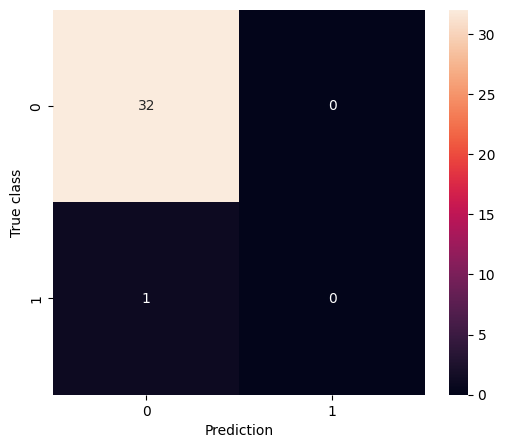

In [142]:
cm = confusion_matrix(logistic_test_data['ragequit_t+3'], round(stat_model.predict(sm.add_constant(logistic_test_data[['Avg. distance', 'Lone Wolf', 'standardized_workload',
 'Organisational Silo', 'Radio Silence',  'black_cloud']]).astype(float))).astype(int))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

### Burnout NB

In [39]:
message_data = all_test[['reply_body', 'ragequit_t+3']].dropna()

nlp = spacy.load('en_core_web_sm')
tqdm.pandas()

message_data['lemmas'] = message_data.reply_body.progress_apply(lambda x: [token.lemma_ for token in nlp(handle_negation(x)) if not token.is_stop and token.is_alpha])
message_data['ragequit_t+3'] = message_data['ragequit_t+3'].astype(bool)
message_data

100%|██████████| 3604/3604 [01:42<00:00, 35.09it/s]


,reply_body,ragequit_t+3,lemmas
0,in we have scenario that there will be multipl...,False,"[scenario, multiple, helix, different, instanc..."
1,"if you are only repo to the code, can we use o...",True,"[repo, code, use, internal, repo, need, pr, wa..."
2,a single there are 4 can they be combined to one,True,"[single, combine]"
3,when writing to a using are corner cases they ...,False,"[write, corner, case, return, ticket, request,..."
5,could you rebase to the head?,False,"[rebase, head]"
...,...,...,...
4245,### issues - [x] my pr addresses the followin...,False,"[issue, x, pr, address, follow, helix, issuesr..."
4246,source code provided on the following the foll...,False,"[source, code, provide, follow, following, str..."
4247,@narendly thank i am contribution is,False,"[thank, contribution]"
4248,@narendly i am i am not sure i NegativeSentime...,False,"[narendly, NegativeSentiment, case, messagethe..."


In [40]:
message_data = message_data[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 0]

message_train, message_test = train_test_split(message_data, test_size=0.15, random_state=404, stratify = message_data['ragequit_t+3'])
message_train, message_val = train_test_split(message_train, test_size=(0.15/0.85), random_state=404, stratify = message_train['ragequit_t+3'])

print(f'length of train set: {len(message_train)}\nlength of validation set: {len(message_val)}\nlength of test set: {len(message_test)}')
message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages

# Oversample on the True cases in the train set
if 2*message_train["ragequit_t+3"].sum()<len(message_train):
   # True is the minority class
    if 3*message_train["ragequit_t+3"].sum()<len(message_train):
        # We need to over- and undersample to create balance
        message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+3"]==1].index], message_train])
        print(f'Positive cases: {message_train["ragequit_t+3"].sum()}')

        if 3*message_train["ragequit_t+3"].sum()<len(message_train):
            # Check for massive imbalance
            message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+3"]==1].index], message_train])
            print(f'Positive cases: {message_train["ragequit_t+3"].sum()}')

        nMax = message_train["ragequit_t+3"].sum()
        message_train = message_train.groupby("ragequit_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')
    else:
        nMax = message_train["ragequit_t+3"].sum()
        # Only undersampling will do
        print(f'Positive cases: {message_train["ragequit_t+3"].sum()}')
        message_train = message_train.groupby("ragequit_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')


else:
    if message_train["ragequit_t+3"].sum()>0.67*len(message_train):
        # False is the minority class and we need to over- and undersample
        message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+3"]==0].index], message_train])
        print(f'Positive cases: {message_train["ragequit_t+3"].sum()}')

        if message_train["ragequit_t+3"].sum()>0.67*len(message_train):
            # Check for massive imbalance (mainly ragequit case)
            message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+3"]==0].index], message_train])
            print(f'Positive cases: {message_train["ragequit_t+3"].sum()}')

        nMax = len(message_train) - message_train["ragequit_t+3"].sum()
        message_train = message_train.groupby("ragequit_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

    else:
        nMax = len(message_train) - message_train["ragequit_t+3"].sum()
        print(f'Positive cases: {message_train["ragequit_t+3"].sum()}')
        message_train = message_train.groupby("ragequit_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

length of train set: 2468
length of validation set: 529
length of test set: 530
Positive cases: 38
Positive cases: 114
New length of train set: 228


C:\Users\woute\AppData\Local\Temp\ipykernel_20520\3232222597.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages
C:\Users\woute\AppData\Local\Temp\ipykernel_20520\3232222597.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  message_train = message_train.groupby("ragequit_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)


In [41]:
pos_labels, pos_values = zip(*Counter(itertools.chain(*message_data[message_data['ragequit_t+3']].lemmas.tolist())).items())
neg_labels, neg_values = zip(*Counter(itertools.chain(*message_data[~message_data['ragequit_t+3']].lemmas.tolist())).items())

importance_df = pd.DataFrame(index = list(set(pos_labels + neg_labels)), data = {'pos_occur': pd.Series(pos_values, index = pos_labels), 'neg_occur': pd.Series(neg_values, index = neg_labels)})
importance_df.fillna(0, inplace = True)
importance_df['total_appearances'] = importance_df['pos_occur'] + importance_df['neg_occur']

for i in range(0,125,25):
    p = i
    importance_df['pos_importance'] = (importance_df['pos_occur'] + p)/(importance_df['total_appearances']+2*p)
    importance_df['neg_importance'] = (importance_df['neg_occur'] + p)/(importance_df['total_appearances']+2*p)
    print(f'positive {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'pos_importance', ascending = False)[['pos_importance', 'pos_occur', 'total_appearances']].head(20))
    print(f'negative {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'neg_importance', ascending = False)[['neg_importance', 'neg_occur', 'total_appearances']].head(20))
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

positive 0:
                   pos_importance  pos_occur  total_appearances
NegativeSentiment        0.032258       10.0              310.0
core                     0.025641        4.0              156.0
java                     0.020690        3.0              145.0
integration              0.017668        5.0              283.0
support                  0.017442        3.0              172.0
paste                    0.015385        2.0              130.0
view                     0.014286        2.0              140.0
version                  0.014286        2.0              140.0
case                     0.013158        2.0              152.0
copy                     0.012500        2.0              160.0
helix                    0.011747       24.0             2043.0
zookeeper                0.011407        3.0              263.0
session                  0.010811        2.0              185.0
list                     0.010753        4.0              372.0
diff                     0.0

In [43]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000)+1, max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = MultinomialNB()
classifier.fit(train_tf, message_train['ragequit_t+3'])

classification_report(message_val['ragequit_t+3'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       1.00      0.89      0.94       525\n        True       0.03      0.50      0.06         4\n\n    accuracy                           0.88       529\n   macro avg       0.51      0.69      0.50       529\nweighted avg       0.99      0.88      0.93       529\n'

Text(45.722222222222214, 0.5, 'True class')

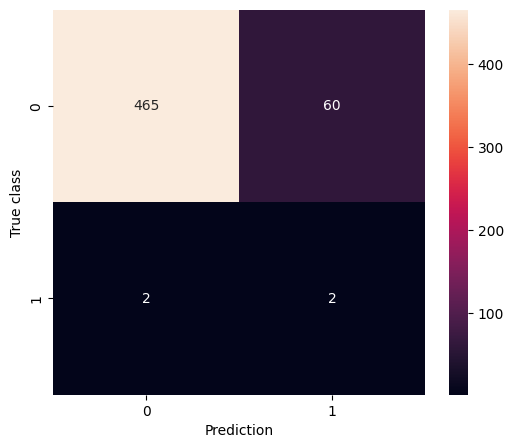

In [44]:
cm = confusion_matrix(message_val['ragequit_t+3'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [45]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+3'])

classification_report(message_val['ragequit_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.99      0.81      0.89       525\n        True       0.01      0.25      0.02         4\n\n    accuracy                           0.80       529\n   macro avg       0.50      0.53      0.45       529\nweighted avg       0.99      0.80      0.88       529\n'

Text(45.722222222222214, 0.5, 'True class')

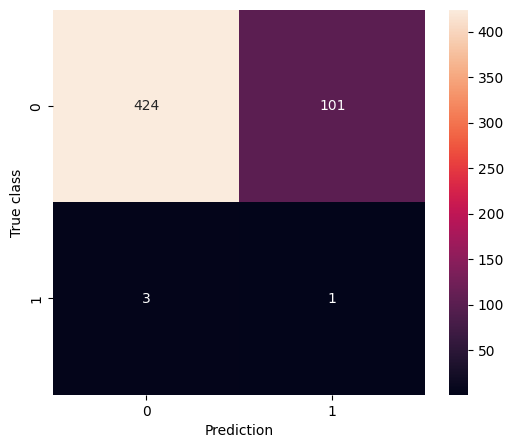

In [46]:
cm = confusion_matrix(message_val['ragequit_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [47]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+3'])

classification_report(message_val['ragequit_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       1.00      0.79      0.88       525\n        True       0.02      0.50      0.03         4\n\n    accuracy                           0.78       529\n   macro avg       0.51      0.64      0.46       529\nweighted avg       0.99      0.78      0.87       529\n'

Text(45.722222222222214, 0.5, 'True class')

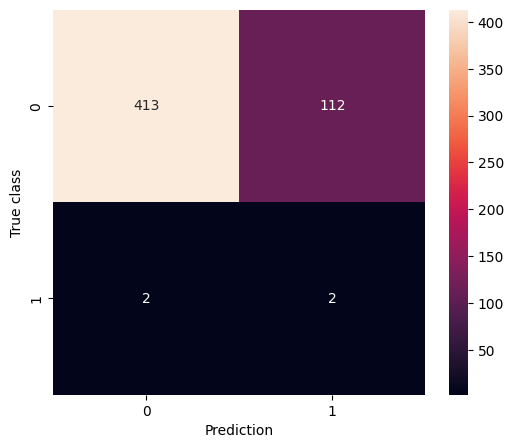

In [48]:
cm = confusion_matrix(message_val['ragequit_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# RF models

In [49]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000)+1, max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(train_tf, message_train['ragequit_t+3'])

classification_report(message_val['ragequit_t+3'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       1.00      1.00      1.00       525\n        True       0.50      0.50      0.50         4\n\n    accuracy                           0.99       529\n   macro avg       0.75      0.75      0.75       529\nweighted avg       0.99      0.99      0.99       529\n'

Text(45.722222222222214, 0.5, 'True class')

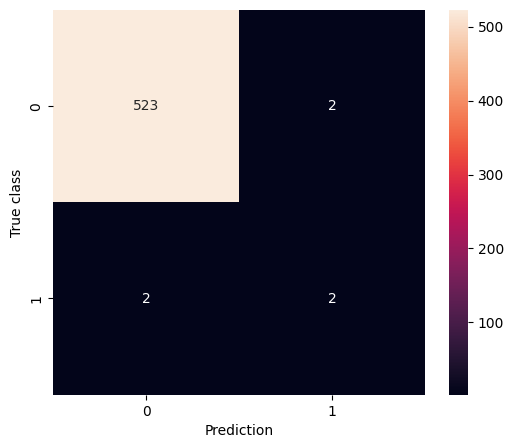

In [50]:
cm = confusion_matrix(message_val['ragequit_t+3'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [51]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+3'])

classification_report(message_val['ragequit_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.99      0.98      0.99       525\n        True       0.00      0.00      0.00         4\n\n    accuracy                           0.97       529\n   macro avg       0.50      0.49      0.49       529\nweighted avg       0.98      0.97      0.98       529\n'

Text(45.722222222222214, 0.5, 'True class')

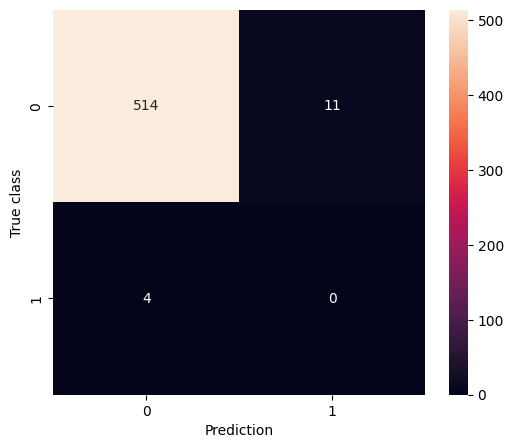

In [52]:
cm = confusion_matrix(message_val['ragequit_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [53]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+3'])

classification_report(message_val['ragequit_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.99      1.00      1.00       525\n        True       0.50      0.25      0.33         4\n\n    accuracy                           0.99       529\n   macro avg       0.75      0.62      0.66       529\nweighted avg       0.99      0.99      0.99       529\n'

Text(45.722222222222214, 0.5, 'True class')

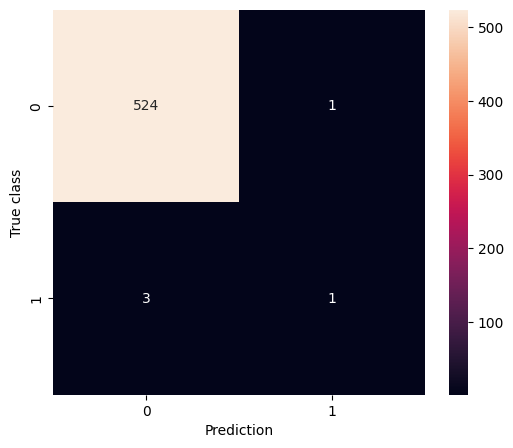

In [54]:
cm = confusion_matrix(message_val['ragequit_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

## Ragequit T+12

In [131]:
burnout_logistic_data = logistic_data[~logistic_data.burnout.isna()].drop(['burnout_t+1', 'burnout_t+3', 'burnout_t+12', 'ragequit_t+1', 'ragequit_t+3', 'burnout', 'git_close'], axis = 1).drop_duplicates().drop(['Alias', 'From', 'To', 'start_datetime', 'end_datetime', 'lagged_burnout', 'reply_close', 'working_months', 'quit', 'first_quit_month', 'git_degree', 'Workload'], axis = 1).dropna().astype({'ragequit_t+12':bool})
logistic_train_data, logistic_test_data = train_test_split(burnout_logistic_data, test_size = 0.2, random_state = 404, stratify = burnout_logistic_data['ragequit_t+12'])


In [132]:
lr_model = LogisticRegressionCV(max_iter = 1000000).fit(logistic_train_data.drop('ragequit_t+12', axis = 1), logistic_train_data['ragequit_t+12'])

Text(45.722222222222214, 0.5, 'True class')

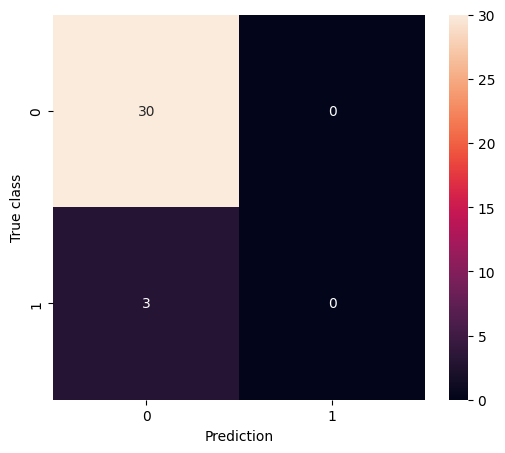

In [133]:
cm = confusion_matrix(logistic_test_data['ragequit_t+12'], lr_model.predict(logistic_test_data.drop('ragequit_t+12', axis = 1)))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

statsmodels

In [134]:
stat_model = sm.Logit(logistic_train_data['ragequit_t+12'].astype(float), sm.add_constant(logistic_train_data[['Avg. distance', 'Lone Wolf', 'standardized_workload',
 'Organisational Silo', 'Radio Silence',  'black_cloud', 'Messages Sent', 'st_congruence', 'reply_between', 'git_between']]).astype(float)).fit(disp = 0)
stat_model.summary()

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          ragequit_t+12   No. Observations:                  129
Model:                          Logit   Df Residuals:                      118
Method:                           MLE   Df Model:                           10
Date:                Thu, 29 May 2025   Pseudo R-squ.:                  0.2916
Time:                        14:51:45   Log-Likelihood:                -31.383
converged:                      False   LL-Null:                       -44.302
Covariance Type:            nonrobust   LLR p-value:                  0.003965
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -26.5597   4.62e+05  -5.75e-05      1.000   -9.06e+05    9.06e+05
Avg. distance            -0.2037      0.550     -0.370      0.711      -1.283       0.875
Lone Wolf                -1.2877      1.401     -0.919      0.358      -4.034       1.458
standardized_workload    -0.6282      0.521     -1.206      0.228      -1.649       0.392
Organisational Silo       0.8294      0.832      0.997      0.319      -0.801       2.460
Radio Silence            27.6722   4.62e+05   5.99e-05      1.000   -9.06e+05    9.06e+05
black_cloud              -1.2901      0.745     -1.732      0.083      -2.750       0.170
Messages Sent            -0.0088      0.017     -0.507      0.612      -0.043       0.025
st_congruence             1.4376      1.807      0.795      0.426      -2.105       4.980
reply_between           -11.8494      4.767     -2.486      0.013     -21.192      -2.507
git_between              -0.0655      1.151     -0.057      0.955      -2.321       2.190
=========================================================================================
"""

Text(45.722222222222214, 0.5, 'True class')

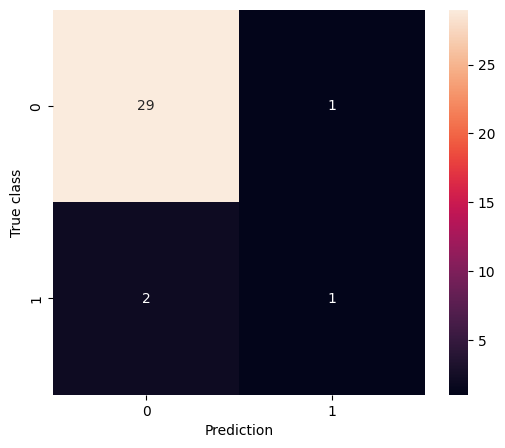

In [135]:
cm = confusion_matrix(logistic_test_data['ragequit_t+12'], round(stat_model.predict(sm.add_constant(logistic_test_data[['Avg. distance', 'Lone Wolf', 'standardized_workload',
 'Organisational Silo', 'Radio Silence',  'black_cloud', 'Messages Sent', 'st_congruence', 'reply_between', 'git_between']]).astype(float))).astype(int))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

### Burnout NB

In [55]:
message_data = all_test[['reply_body', 'ragequit_t+12']].dropna()

nlp = spacy.load('en_core_web_sm')
tqdm.pandas()

message_data['lemmas'] = message_data.reply_body.progress_apply(lambda x: [token.lemma_ for token in nlp(handle_negation(x)) if not token.is_stop and token.is_alpha])
message_data['ragequit_t+12'] = message_data['ragequit_t+12'].astype(bool)
message_data

100%|██████████| 3604/3604 [01:50<00:00, 32.72it/s]


,reply_body,ragequit_t+12,lemmas
0,in we have scenario that there will be multipl...,False,"[scenario, multiple, helix, different, instanc..."
1,"if you are only repo to the code, can we use o...",True,"[repo, code, use, internal, repo, need, pr, wa..."
2,a single there are 4 can they be combined to one,True,"[single, combine]"
3,when writing to a using are corner cases they ...,False,"[write, corner, case, return, ticket, request,..."
5,could you rebase to the head?,False,"[rebase, head]"
...,...,...,...
4245,### issues - [x] my pr addresses the followin...,False,"[issue, x, pr, address, follow, helix, issuesr..."
4246,source code provided on the following the foll...,False,"[source, code, provide, follow, following, str..."
4247,@narendly thank i am contribution is,False,"[thank, contribution]"
4248,@narendly i am i am not sure i NegativeSentime...,False,"[narendly, NegativeSentiment, case, messagethe..."


In [56]:
message_data = message_data[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 0]

message_train, message_test = train_test_split(message_data, test_size=0.15, random_state=404, stratify = message_data['ragequit_t+12'])
message_train, message_val = train_test_split(message_train, test_size=(0.15/0.85), random_state=404, stratify = message_train['ragequit_t+12'])

print(f'length of train set: {len(message_train)}\nlength of validation set: {len(message_val)}\nlength of test set: {len(message_test)}')
message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages

# Oversample on the True cases in the train set
if 2*message_train["ragequit_t+12"].sum()<len(message_train):
   # True is the minority class
    if 3*message_train["ragequit_t+12"].sum()<len(message_train):
        # We need to over- and undersample to create balance
        message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+12"]==1].index], message_train])
        print(f'Positive cases: {message_train["ragequit_t+12"].sum()}')

        if 3*message_train["ragequit_t+12"].sum()<len(message_train):
            # Check for massive imbalance
            message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+12"]==1].index], message_train])
            print(f'Positive cases: {message_train["ragequit_t+12"].sum()}')

        nMax = message_train["ragequit_t+12"].sum()
        message_train = message_train.groupby("ragequit_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')
    else:
        nMax = message_train["ragequit_t+12"].sum()
        # Only undersampling will do
        print(f'Positive cases: {message_train["ragequit_t+12"].sum()}')
        message_train = message_train.groupby("ragequit_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')


else:
    if message_train["ragequit_t+12"].sum()>0.67*len(message_train):
        # False is the minority class and we need to over- and undersample
        message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+12"]==0].index], message_train])
        print(f'Positive cases: {message_train["ragequit_t+12"].sum()}')

        if message_train["ragequit_t+12"].sum()>0.67*len(message_train):
            # Check for massive imbalance (mainly ragequit case)
            message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+12"]==0].index], message_train])
            print(f'Positive cases: {message_train["ragequit_t+12"].sum()}')

        nMax = len(message_train) - message_train["ragequit_t+12"].sum()
        message_train = message_train.groupby("ragequit_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

    else:
        nMax = len(message_train) - message_train["ragequit_t+12"].sum()
        print(f'Positive cases: {message_train["ragequit_t+12"].sum()}')
        message_train = message_train.groupby("ragequit_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

length of train set: 2468
length of validation set: 529
length of test set: 530
Positive cases: 84
Positive cases: 252
New length of train set: 504


C:\Users\woute\AppData\Local\Temp\ipykernel_20520\2668262174.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages
C:\Users\woute\AppData\Local\Temp\ipykernel_20520\2668262174.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  message_train = message_train.groupby("ragequit_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)


In [57]:
pos_labels, pos_values = zip(*Counter(itertools.chain(*message_data[message_data['ragequit_t+12']].lemmas.tolist())).items())
neg_labels, neg_values = zip(*Counter(itertools.chain(*message_data[~message_data['ragequit_t+12']].lemmas.tolist())).items())

importance_df = pd.DataFrame(index = list(set(pos_labels + neg_labels)), data = {'pos_occur': pd.Series(pos_values, index = pos_labels), 'neg_occur': pd.Series(neg_values, index = neg_labels)})
importance_df.fillna(0, inplace = True)
importance_df['total_appearances'] = importance_df['pos_occur'] + importance_df['neg_occur']

for i in range(0,125,25):
    p = i
    importance_df['pos_importance'] = (importance_df['pos_occur'] + p)/(importance_df['total_appearances']+2*p)
    importance_df['neg_importance'] = (importance_df['neg_occur'] + p)/(importance_df['total_appearances']+2*p)
    print(f'positive {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'pos_importance', ascending = False)[['pos_importance', 'pos_occur', 'total_appearances']].head(20))
    print(f'negative {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'neg_importance', ascending = False)[['neg_importance', 'neg_occur', 'total_appearances']].head(20))
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

positive 0:
                   pos_importance  pos_occur  total_appearances
core                     0.064103       10.0              156.0
delete                   0.056250        9.0              160.0
release                  0.052980       16.0              302.0
previous                 0.049505        5.0              101.0
exist                    0.046784        8.0              171.0
start                    0.044643        5.0              112.0
implementation           0.043796        6.0              137.0
master                   0.036697        4.0              109.0
expect                   0.036675       15.0              409.0
logic                    0.036474       12.0              329.0
exception                0.033557        5.0              149.0
NegativeSentiment        0.032258       10.0              310.0
node                     0.029412        6.0              204.0
maven                    0.029070        5.0              172.0
movement                 0.0

In [58]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000)+1, max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = MultinomialNB()
classifier.fit(train_tf, message_train['ragequit_t+12'])

classification_report(message_val['ragequit_t+12'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.99      0.85      0.92       518\n        True       0.09      0.73      0.16        11\n\n    accuracy                           0.85       529\n   macro avg       0.54      0.79      0.54       529\nweighted avg       0.97      0.85      0.90       529\n'

Text(45.722222222222214, 0.5, 'True class')

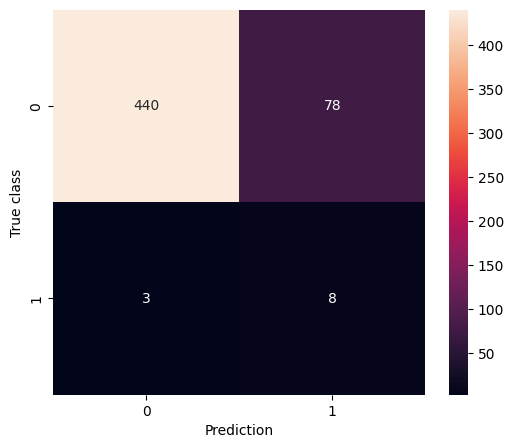

In [59]:
cm = confusion_matrix(message_val['ragequit_t+12'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [60]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+12'])

classification_report(message_val['ragequit_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.99      0.59      0.74       518\n        True       0.03      0.64      0.06        11\n\n    accuracy                           0.59       529\n   macro avg       0.51      0.61      0.40       529\nweighted avg       0.97      0.59      0.73       529\n'

Text(45.722222222222214, 0.5, 'True class')

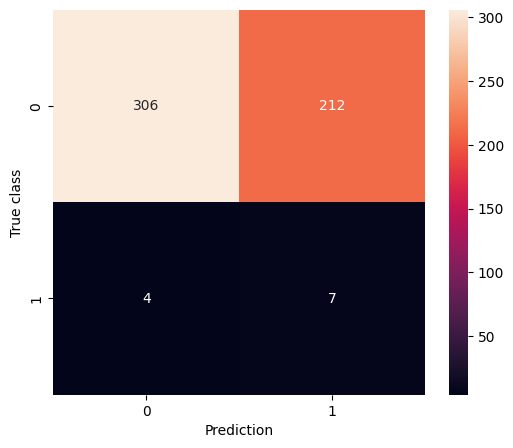

In [61]:
cm = confusion_matrix(message_val['ragequit_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [62]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+12'])

classification_report(message_val['ragequit_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.99      0.86      0.92       518\n        True       0.08      0.55      0.14        11\n\n    accuracy                           0.86       529\n   macro avg       0.53      0.71      0.53       529\nweighted avg       0.97      0.86      0.91       529\n'

Text(45.722222222222214, 0.5, 'True class')

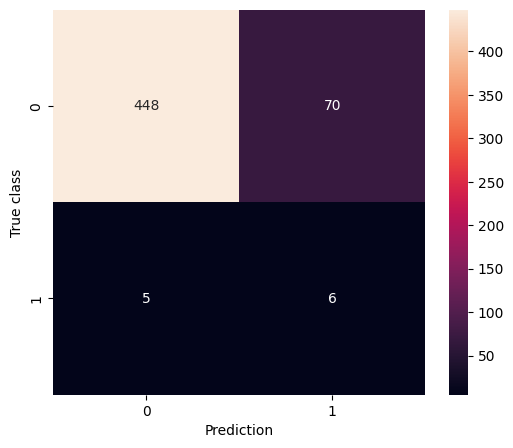

In [63]:
cm = confusion_matrix(message_val['ragequit_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# RF models

In [64]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000)+1, max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(train_tf, message_train['ragequit_t+12'])

classification_report(message_val['ragequit_t+12'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.99      0.98      0.98       518\n        True       0.31      0.45      0.37        11\n\n    accuracy                           0.97       529\n   macro avg       0.65      0.72      0.68       529\nweighted avg       0.97      0.97      0.97       529\n'

Text(45.722222222222214, 0.5, 'True class')

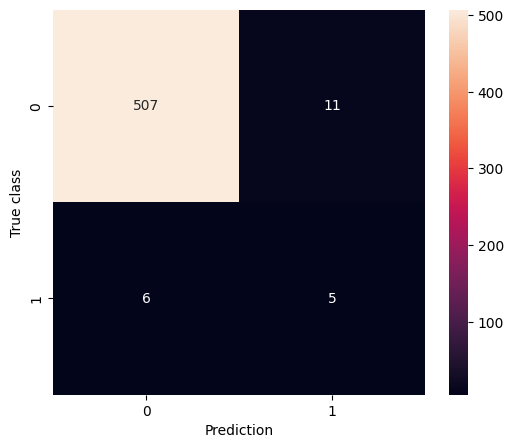

In [65]:
cm = confusion_matrix(message_val['ragequit_t+12'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [66]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+12'])

classification_report(message_val['ragequit_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.98      0.97      0.97       518\n        True       0.10      0.18      0.13        11\n\n    accuracy                           0.95       529\n   macro avg       0.54      0.57      0.55       529\nweighted avg       0.96      0.95      0.96       529\n'

Text(45.722222222222214, 0.5, 'True class')

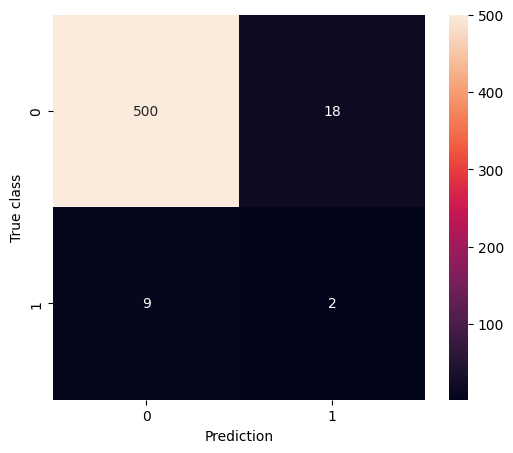

In [67]:
cm = confusion_matrix(message_val['ragequit_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [68]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+12'])

classification_report(message_val['ragequit_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.99      0.98      0.99       518\n        True       0.33      0.36      0.35        11\n\n    accuracy                           0.97       529\n   macro avg       0.66      0.67      0.67       529\nweighted avg       0.97      0.97      0.97       529\n'

Text(45.722222222222214, 0.5, 'True class')

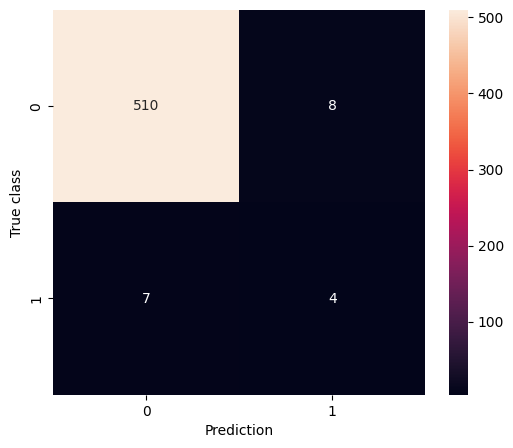

In [69]:
cm = confusion_matrix(message_val['ragequit_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')